In [38]:
import gym
from gym import spaces
import numpy as np

# Define the COVID-19 and Flu Vaccine RL Environments
class VaccineEnv(gym.Env):
    def __init__(self, disease_type="COVID"):
        super(VaccineEnv, self).__init__()
        self.disease_type = disease_type

        # Define state space based on the disease type
        if self.disease_type == "COVID":
            self.state_size = 10  # COVID-19 has more dynamic variables
        else:
            self.state_size = 8  # Flu has fewer, as it's more seasonal

        self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(6)  # Six actions: allocate, prioritize, boost supply, etc.

    def step(self, action):
        state = self.get_state()
        reward = self.calculate_reward(state, action)
        done = False  # The environment is episodic but continuous over multiple steps
        return state, reward, done, {}

    def calculate_reward(self, state, action):
        """Define reward function based on state and action."""
        if self.disease_type == "COVID":
            hospitalization_rate = state[0]
            death_rate = state[1]
            vaccination_coverage = state[2]
            vaccine_wastage = state[3]
            variant_severity = state[4]
            booster_demand = state[5]

            reward = (
                - (hospitalization_rate * 10)  # High hospitalizations = bad
                - (death_rate * 20)  # High deaths = bad
                + (vaccination_coverage * 5)  # More people vaccinated = good
                - (vaccine_wastage * 8)  # Wasting doses = bad
                + (variant_severity * booster_demand * 5)  # High variant severity = more boosters needed
            )

        else:  # Flu reward function
            flu_hospitalization_rate = state[0]
            flu_death_rate = state[1]
            flu_vaccination_coverage = state[2]
            flu_wastage = state[3]
            flu_seasonality_factor = state[4]

            reward = (
                - (flu_hospitalization_rate * 10)  # More flu hospitalizations = bad
                - (flu_death_rate * 15)  # More flu deaths = bad
                + (flu_vaccination_coverage * 6)  # More flu vaccinations = good
                - (flu_wastage * 7)  # Wasting flu vaccines = bad
                + (flu_seasonality_factor * 5)  # More vaccines needed in peak flu season
            )

        return reward

    def get_state(self):
        """Generate a random state representation."""
        return np.random.rand(self.state_size)

    def reset(self):
        """Reset the environment."""
        return self.get_state()

# Initialize separate RL environments for COVID-19 and Flu
covid_env = VaccineEnv("COVID")
flu_env = VaccineEnv("FLU")

# Verify environments
covid_state = covid_env.reset()
flu_state = flu_env.reset()

# Take a random action and observe results
covid_action = covid_env.action_space.sample()
flu_action = flu_env.action_space.sample()

covid_next_state, covid_reward, _, _ = covid_env.step(covid_action)
flu_next_state, flu_reward, _, _ = flu_env.step(flu_action)

# Display sample outputs
covid_reward, flu_reward


(-17.102119531742847, -15.805142988736119)

In [39]:
# import gym
# import pandas as pd
# from gym import spaces

# # Define the RL Environment using this synthetic population data
# class VaccineEnv(gym.Env):
#     def __init__(self, disease_type="COVID"):
#         super(VaccineEnv, self).__init__()
#         self.disease_type = disease_type

#         # Load synthetic population dataset
#         self.population_data = pd.read_csv(folder_path + "synthetic_population_data.csv")

#         # Define state space (10 for COVID, 8 for Flu)
#         self.state_size = 10 if self.disease_type == "COVID" else 8
#         self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
#         self.action_space = spaces.Discrete(6)  # Six actions: allocate, prioritize, boost supply, etc.

#     def get_state(self):
#         """Retrieve a random real-world-inspired state from synthetic data."""
#         random_state = self.population_data.sample(1).iloc[0]

#         # Convert selected region data into a state vector
#         state = np.array([
#             random_state["hospitalization_rate"],
#             random_state["death_rate"],
#             random_state["vaccine_supply"],
#             random_state["vaccine_hesitancy"],
#             random_state["booster_demand"],
#             random_state["variant_severity"] if self.disease_type == "COVID" else random_state["seasonality_factor"]
#         ], dtype=np.float32)

#         return state

#     def step(self, action):
#         state = self.get_state()
#         reward = self.calculate_reward(state, action)
#         done = False  # The environment is episodic but continuous over multiple steps
#         return state, reward, done, {}

#     def calculate_reward(self, state, action):
#         """Define reward function based on state and action."""
#         hospitalization_rate = state[0]
#         death_rate = state[1]
#         vaccination_coverage = state[2]
#         vaccine_hesitancy = state[3]
#         booster_demand = state[4]

#         if self.disease_type == "COVID":
#             variant_severity = state[5]
#             reward = (
#                 - (hospitalization_rate * 10)
#                 - (death_rate * 20)
#                 + (vaccination_coverage * 5)
#                 - (vaccine_hesitancy * 8)
#                 + (variant_severity * booster_demand * 7)
#             )
#         else:  # Flu reward function
#             seasonality_factor = state[5]
#             reward = (
#                 - (hospitalization_rate * 10)
#                 - (death_rate * 15)
#                 + (vaccination_coverage * 6)
#                 - (vaccine_hesitancy * 7)
#                 + (seasonality_factor * 5)
#             )

#         return reward

#     def reset(self):
#         """Reset the environment."""
#         return self.get_state()

# # Initialize RL Environments
# covid_env = VaccineEnv("COVID")
# flu_env = VaccineEnv("FLU")

# print("✅ RL Environment Initialized with Synthetic Data.")

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Training parameters
num_episodes = 500
learning_rate = 0.01
gamma = 0.95

# Initialize the COVID-19 RL environment
covid_env = VaccineEnv("COVID")
state_dim = covid_env.state_size
action_dim = covid_env.action_space.n

# Initialize the Q-network and optimizer
q_network = DQN(state_dim, action_dim)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Initialize a list to store rewards per episode
reward_history = []

# Training loop
for episode in range(num_episodes):
    state = covid_env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    total_reward = 0
    for _ in range(50):  # Limit episode length
        action = random.choice(range(action_dim))  # Random action for now
        next_state, reward, done, _ = covid_env.step(action)

        next_state = torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)

        # Q-learning update
        target = reward + gamma * torch.max(q_network(next_state))
        prediction = q_network(state)[action]
        loss = loss_fn(prediction, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        total_reward += reward.item()

        if done:
            break

    # Store reward for visualization
    reward_history.append(total_reward)

    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}")

print("✅ COVID-19 RL Agent Training Complete")

Episode 1: Total Reward = -700.34
Episode 2: Total Reward = -876.32
Episode 3: Total Reward = -731.92
Episode 4: Total Reward = -821.50
Episode 5: Total Reward = -875.03
Episode 6: Total Reward = -734.69
Episode 7: Total Reward = -677.07
Episode 8: Total Reward = -773.31
Episode 9: Total Reward = -707.02
Episode 10: Total Reward = -767.16
Episode 11: Total Reward = -764.59
Episode 12: Total Reward = -736.67
Episode 13: Total Reward = -714.48
Episode 14: Total Reward = -736.69
Episode 15: Total Reward = -784.26
Episode 16: Total Reward = -762.20
Episode 17: Total Reward = -740.79
Episode 18: Total Reward = -811.96
Episode 19: Total Reward = -784.73
Episode 20: Total Reward = -738.83
Episode 21: Total Reward = -700.64
Episode 22: Total Reward = -760.05
Episode 23: Total Reward = -718.10
Episode 24: Total Reward = -767.64
Episode 25: Total Reward = -689.29
Episode 26: Total Reward = -797.08
Episode 27: Total Reward = -776.25
Episode 28: Total Reward = -777.16
Episode 29: Total Reward = -8

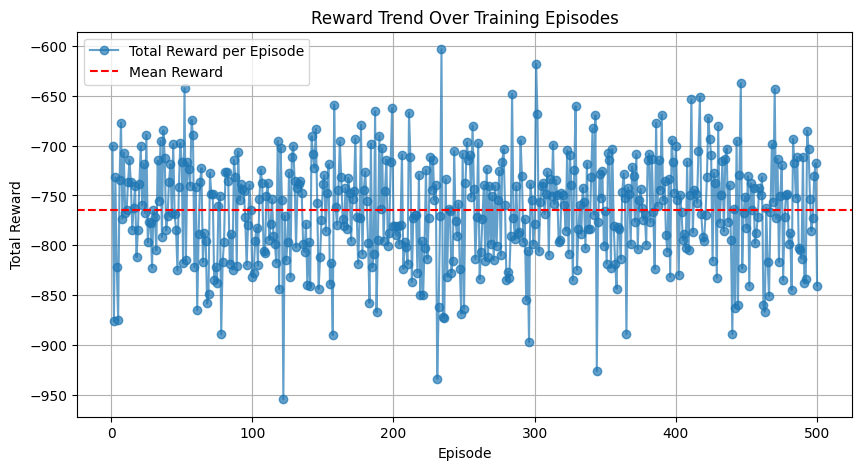

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert reward history into a DataFrame
df = pd.DataFrame({"Episode": range(1, len(reward_history) + 1), "Reward": reward_history})

# Plot the reward trend
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], marker="o", linestyle="-", alpha=0.7, label="Total Reward per Episode")
plt.axhline(y=df["Reward"].mean(), color="red", linestyle="--", label="Mean Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Trend Over Training Episodes")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Training parameters
num_episodes = 500
learning_rate = 0.01
gamma = 0.95

# Initialize the COVID-19 RL environment
covid_env = VaccineEnv("FLU")
state_dim = covid_env.state_size
action_dim = covid_env.action_space.n

# Initialize the Q-network and optimizer
q_network = DQN(state_dim, action_dim)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Training loop
for episode in range(num_episodes):
    state = covid_env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    total_reward = 0
    for _ in range(50):  # Limit episode length
        action = random.choice(range(action_dim))  # Random action for now
        next_state, reward, done, _ = covid_env.step(action)

        next_state = torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)

        # Q-learning update
        target = reward + gamma * torch.max(q_network(next_state))
        prediction = q_network(state)[action]
        loss = loss_fn(prediction, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        total_reward += reward.item()

        if done:
            break

    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}")

print("✅ FLU RL Agent Training Complete")


Episode 1: Total Reward = -530.26
Episode 2: Total Reward = -561.00
Episode 3: Total Reward = -596.04
Episode 4: Total Reward = -505.57
Episode 5: Total Reward = -506.43
Episode 6: Total Reward = -505.99
Episode 7: Total Reward = -610.61
Episode 8: Total Reward = -586.48
Episode 9: Total Reward = -555.06
Episode 10: Total Reward = -614.91
Episode 11: Total Reward = -495.80
Episode 12: Total Reward = -485.41
Episode 13: Total Reward = -452.49
Episode 14: Total Reward = -478.71
Episode 15: Total Reward = -543.07
Episode 16: Total Reward = -565.56
Episode 17: Total Reward = -437.10
Episode 18: Total Reward = -544.83
Episode 19: Total Reward = -557.99
Episode 20: Total Reward = -496.66
Episode 21: Total Reward = -518.40
Episode 22: Total Reward = -565.20
Episode 23: Total Reward = -532.46
Episode 24: Total Reward = -482.27
Episode 25: Total Reward = -553.65
Episode 26: Total Reward = -415.51
Episode 27: Total Reward = -504.66
Episode 28: Total Reward = -546.30
Episode 29: Total Reward = -4

In [42]:
# class MultiVaccineEnv(gym.Env):
#     def __init__(self):
#         super(MultiVaccineEnv, self).__init__()

#         self.covid_env = VaccineEnv("COVID")
#         self.flu_env = VaccineEnv("FLU")

#         # Combine both state spaces
#         self.state_size = self.covid_env.state_size + self.flu_env.state_size
#         self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
#         self.action_space = spaces.Discrete(12)  # Actions for both vaccines

#     def step(self, action):
#         covid_action = action % 6
#         flu_action = action // 6

#         covid_state, covid_reward, _, _ = self.covid_env.step(covid_action)
#         flu_state, flu_reward, _, _ = self.flu_env.step(flu_action)

#         combined_state = np.concatenate([covid_state, flu_state])
#         combined_reward = self.calculate_reward(covid_state, flu_state, covid_action, flu_action)

#         # Termination condition: If hospitalization rate exceeds a threshold or 90% coverage achieved
#         done = (covid_state[0] > 0.3 or flu_state[0] > 0.3) or \
#             (covid_state[2] > 0.9 and flu_state[2] > 0.9)

#         return combined_state, combined_reward, done, {}

#     def reset(self):
#         covid_state = self.covid_env.reset()
#         flu_state = self.flu_env.reset()
#         return np.concatenate([covid_state, flu_state])

# Initialize the Multi-Vaccine RL Agent
# multi_vaccine_env = MultiVaccineEnv()


In [ ]:
# class MultiVaccineEnv(gym.Env):
#     def __init__(self):
#         super(MultiVaccineEnv, self).__init__()

#         self.covid_env = VaccineEnv("COVID")
#         self.flu_env = VaccineEnv("FLU")

#         # Combine both state spaces
#         self.state_size = self.covid_env.state_size + self.flu_env.state_size
#         self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
#         self.action_space = spaces.Discrete(12)  # Actions for both vaccines

#     def step(self, action):
#         covid_action = action % 6  # Map actions for COVID
#         flu_action = action // 6  # Map actions for Flu

#         covid_state, covid_reward, _, _ = self.covid_env.step(covid_action)
#         flu_state, flu_reward, _, _ = self.flu_env.step(flu_action)

#         combined_state = np.concatenate([covid_state, flu_state])
#         combined_reward = covid_reward + flu_reward  # ✅ Use direct rewards from sub-environments

#         # ✅ Termination condition: If hospitalization rate exceeds a threshold or 90% coverage achieved
#         done = (covid_state[0] > 0.3 or flu_state[0] > 0.3) or \
#                (covid_state[2] > 0.9 and flu_state[2] > 0.9)

#         return combined_state, combined_reward, done, {}

#     def reset(self):
#         covid_state = self.covid_env.reset()
#         flu_state = self.flu_env.reset()
        
#         combined_state = np.concatenate([covid_state, flu_state])

#         if len(combined_state) != self.state_size:
#             print(f"⚠️ Warning: Expected state size {self.state_size}, but got {len(combined_state)}")
        
#         return combined_state



In [105]:
# Import MultiVaccineEnv
class MultiVaccineEnv(gym.Env):
    def __init__(self):
        super(MultiVaccineEnv, self).__init__()
        self.covid_env = VaccineEnv("COVID")
        self.flu_env = VaccineEnv("FLU")

        self.state_size = self.covid_env.state_size + self.flu_env.state_size
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(12)

    def step(self, action):
        covid_action = action % 6  
        flu_action = action // 6  

        covid_state, covid_reward, _, _ = self.covid_env.step(covid_action)
        flu_state, flu_reward, _, _ = self.flu_env.step(flu_action)

        combined_state = np.concatenate([covid_state, flu_state])
        combined_reward = covid_reward + flu_reward  

        done = (covid_state[0] > 0.3 or flu_state[0] > 0.3) or \
               (covid_state[2] > 0.9 and flu_state[2] > 0.9)

        return combined_state, combined_reward, done, {}

    def reset(self):
        covid_state = self.covid_env.reset()
        flu_state = self.flu_env.reset()
        return np.concatenate([covid_state, flu_state])

In [106]:
# Initialize the Multi-Vaccine RL Agent
multi_vaccine_env = MultiVaccineEnv()

state = multi_vaccine_env.reset()  # Reset environment and get initial state 

for _ in range(10):  # Run for 10 steps
    action = multi_vaccine_env.action_space.sample()  # Take a random action
    next_state, reward, done, _ = multi_vaccine_env.step(action)
    print(f"State: {next_state}, Reward: {reward}")

    if done:
        break  # Stop if the environment ends


State: [0.615887   0.09920019 0.2021689  0.17086975 0.84465002 0.39542948
 0.19635043 0.91538441 0.81819193 0.74120063 0.802277   0.10730258
 0.96716403 0.37135959 0.67773021 0.89614067 0.02960573 0.84919952], Reward: -9.86918016811969


Episode 0: Total Reward = -30.23
Episode 50: Total Reward = -29.93
Episode 100: Total Reward = -35.93
Episode 150: Total Reward = -35.15
Episode 200: Total Reward = -34.65
Episode 250: Total Reward = -7.29
Episode 300: Total Reward = -42.63
Episode 350: Total Reward = -15.81
Episode 400: Total Reward = -16.16
Episode 450: Total Reward = -34.17


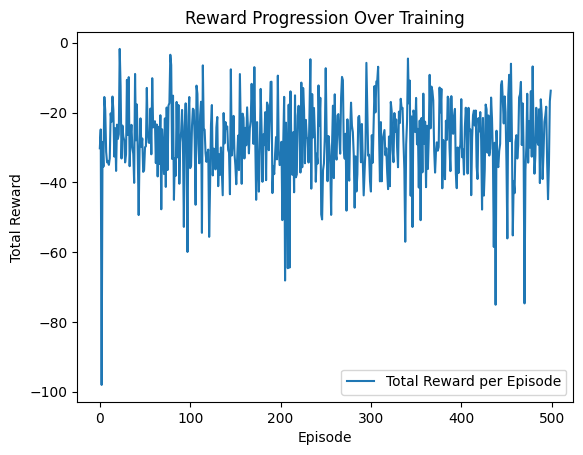

In [107]:
import matplotlib.pyplot as plt

# Track rewards over episodes
num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    state = multi_vaccine_env.reset()
    total_reward = 0

    for _ in range(50):  # Limit steps per episode (adjust as needed)
        action = multi_vaccine_env.action_space.sample()  # Take a random action
        next_state, reward, done, _ = multi_vaccine_env.step(action)
        total_reward += reward  # Accumulate reward

        if done:
            break  # Stop if episode ends

    reward_history.append(total_reward)  # Store reward

    # Print progress every 50 episodes
    if episode % 50 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward:.2f}")

# Plot reward progression
plt.plot(reward_history, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Progression Over Training")
plt.legend()
plt.show()


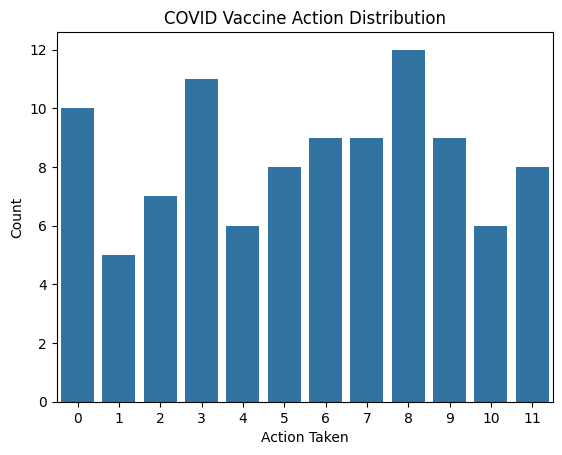

In [108]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

action_counts = []

for _ in range(100):  # Run 100 steps
    action = multi_vaccine_env.action_space.sample()  # Sample action
    action_counts.append(action)  # Directly append the integer action

# Convert to DataFrame for plotting
action_df = pd.DataFrame({"Action": action_counts})

# ✅ Visualize action distribution
sns.countplot(data=action_df, x="Action")
plt.xlabel("Action Taken")
plt.ylabel("Count")
plt.title("COVID Vaccine Action Distribution")
plt.show()


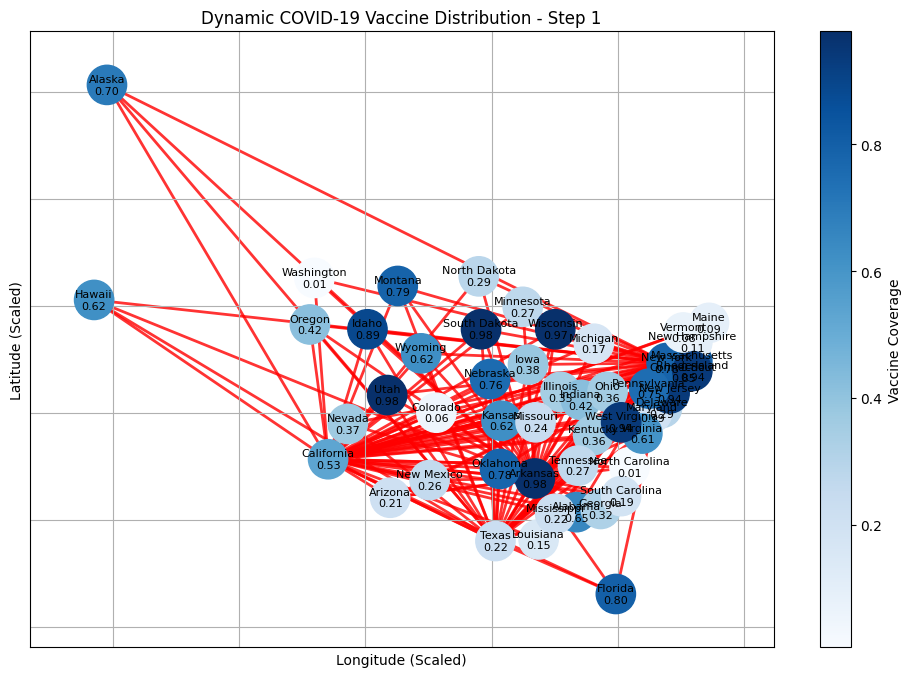


COVID Vaccine Coverage Table - Step 1

         State  COVID Vaccine Coverage
       Alabama                0.652616
        Alaska                0.702617
       Arizona                0.211193
      Arkansas                0.977860
    California                0.532572
      Colorado                0.056094
   Connecticut                0.850100
      Delaware                0.291447
       Florida                0.799614
       Georgia                0.324686
        Hawaii                0.618005
         Idaho                0.890228
      Illinois                0.346060
       Indiana                0.422771
          Iowa                0.384200
        Kansas                0.622925
      Kentucky                0.356622
     Louisiana                0.154114
         Maine                0.094610
      Maryland                0.193478
 Massachusetts                0.801478
      Michigan                0.172632
     Minnesota                0.273022
   Mississippi          

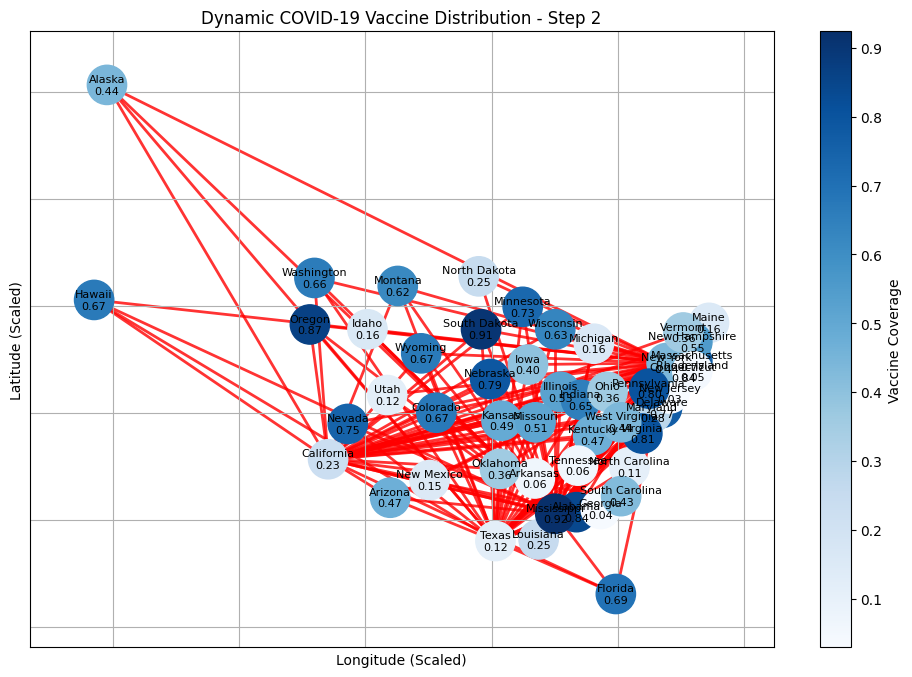


COVID Vaccine Coverage Table - Step 2

         State  COVID Vaccine Coverage
       Alabama                0.841825
        Alaska                0.444260
       Arizona                0.470611
      Arkansas                0.064100
    California                0.229327
      Colorado                0.673302
   Connecticut                0.835763
      Delaware                0.768942
       Florida                0.694707
       Georgia                0.035499
        Hawaii                0.671397
         Idaho                0.164865
      Illinois                0.525105
       Indiana                0.651714
          Iowa                0.398246
        Kansas                0.491523
      Kentucky                0.469860
     Louisiana                0.249434
         Maine                0.157768
      Maryland                0.283190
 Massachusetts                0.765631
      Michigan                0.161024
     Minnesota                0.729202
   Mississippi          

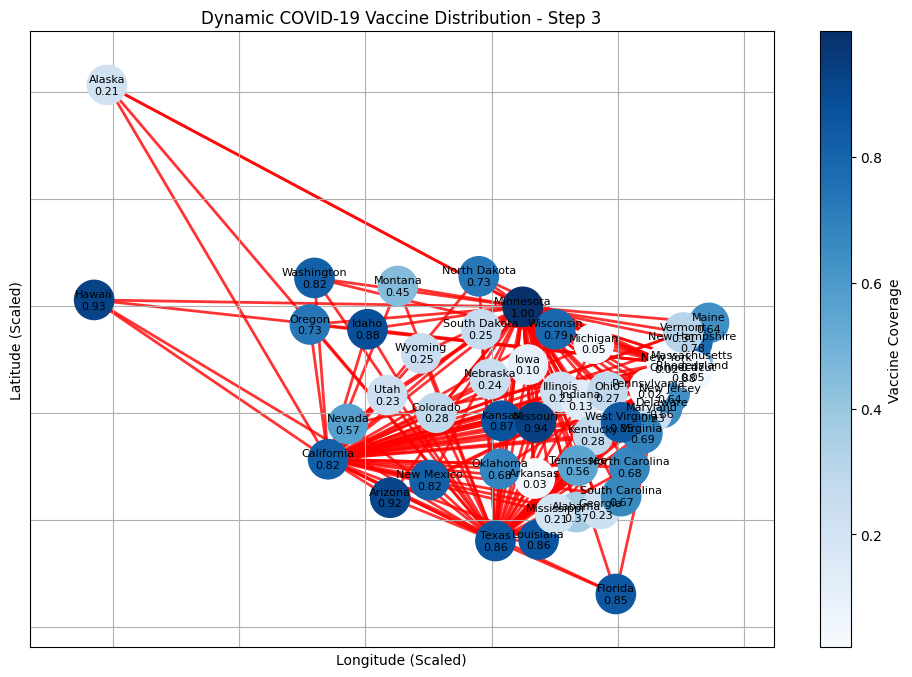


COVID Vaccine Coverage Table - Step 3

         State  COVID Vaccine Coverage
       Alabama                0.369855
        Alaska                0.213683
       Arizona                0.921864
      Arkansas                0.032482
    California                0.821692
      Colorado                0.283081
   Connecticut                0.882164
      Delaware                0.658329
       Florida                0.847438
       Georgia                0.230487
        Hawaii                0.928929
         Idaho                0.884331
      Illinois                0.225044
       Indiana                0.133460
          Iowa                0.101179
        Kansas                0.869547
      Kentucky                0.279034
     Louisiana                0.856174
         Maine                0.636461
      Maryland                0.231107
 Massachusetts                0.474879
      Michigan                0.046298
     Minnesota                0.999429
   Mississippi          

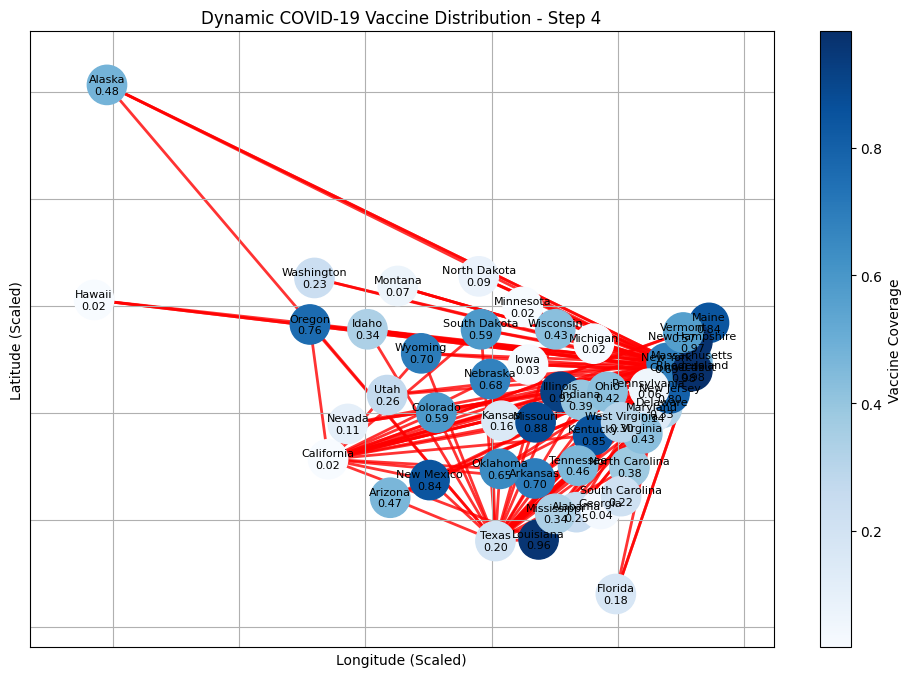


COVID Vaccine Coverage Table - Step 4

         State  COVID Vaccine Coverage
       Alabama                0.250600
        Alaska                0.478121
       Arizona                0.465817
      Arkansas                0.697705
    California                0.017969
      Colorado                0.588982
   Connecticut                0.975112
      Delaware                0.332193
       Florida                0.175714
       Georgia                0.037180
        Hawaii                0.019498
         Idaho                0.335102
      Illinois                0.924760
       Indiana                0.394976
          Iowa                0.025868
        Kansas                0.155817
      Kentucky                0.852417
     Louisiana                0.962994
         Maine                0.843979
      Maryland                0.142009
 Massachusetts                0.488258
      Michigan                0.021527
     Minnesota                0.017716
   Mississippi          

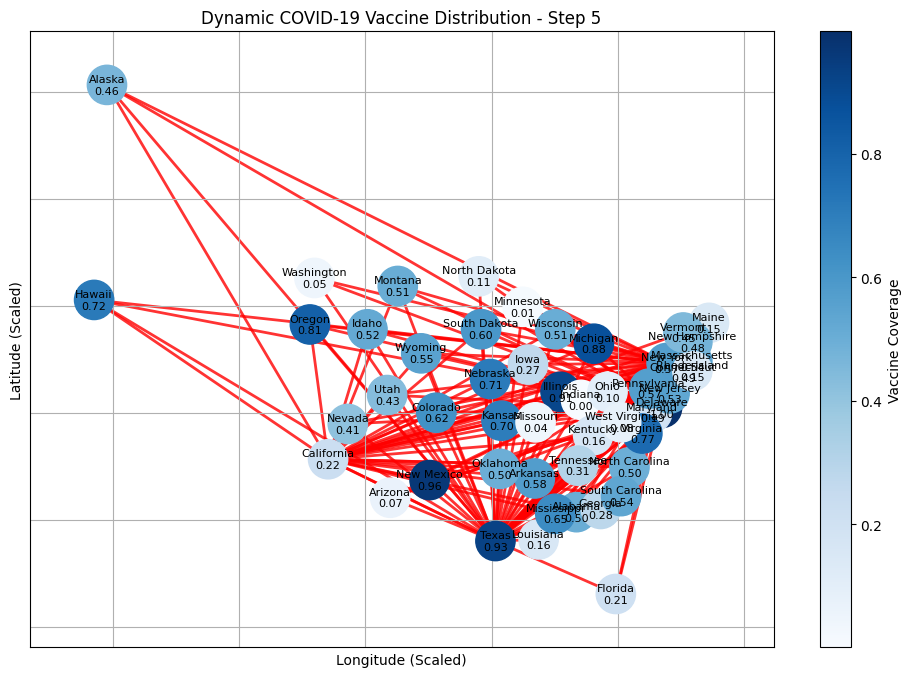


COVID Vaccine Coverage Table - Step 5

         State  COVID Vaccine Coverage
       Alabama                0.503330
        Alaska                0.464254
       Arizona                0.067058
      Arkansas                0.577090
    California                0.222639
      Colorado                0.623111
   Connecticut                0.487794
      Delaware                0.998091
       Florida                0.208652
       Georgia                0.281686
        Hawaii                0.716495
         Idaho                0.519675
      Illinois                0.914888
       Indiana                0.000508
          Iowa                0.268729
        Kansas                0.703088
      Kentucky                0.162930
     Louisiana                0.158440
         Maine                0.150110
      Maryland                0.194790
 Massachusetts                0.542922
      Michigan                0.876054
     Minnesota                0.009452
   Mississippi          

In [127]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

env = MultiVaccineEnv()

# ✅ Adjust positions: Keep Alaska & Hawaii fixed, center and spread the lower 48
scale_factor = 3  # Scaling factor for visualization
center_shift = (-98, 39)  # Rough center of the continental US to shift states

state_coords = {}
raw_coords = {
    'Alabama': (32.8, -86.8), 'Alaska': (61.3, -152.4), 'Arizona': (33.7, -111.4),
    'Arkansas': (34.9, -92.3), 'California': (36.1, -119.6), 'Colorado': (39.0, -105.3),
    'Connecticut': (41.5, -72.7), 'Delaware': (39.3, -75.5), 'Florida': (27.7, -81.6),
    'Georgia': (33.0, -83.6), 'Hawaii': (21.09, -157.49), 'Idaho': (44.2, -114.4),
    'Illinois': (40.3, -88.9), 'Indiana': (39.8, -86.2), 'Iowa': (42.0, -93.2),
    'Kansas': (38.5, -96.7), 'Kentucky': (37.6, -84.6), 'Louisiana': (31.1, -91.8),
    'Maine': (44.6, -69.3), 'Maryland': (39.0, -76.8), 'Massachusetts': (42.2, -71.5),
    'Michigan': (43.3, -84.5), 'Minnesota': (45.6, -93.9), 'Mississippi': (32.7, -89.6),
    'Missouri': (38.4, -92.2), 'Montana': (46.9, -110.4), 'Nebraska': (41.1, -98.2),
    'Nevada': (38.3, -117.0), 'New Hampshire': (43.4, -71.5), 'New Jersey': (40.2, -74.5),
    'New Mexico': (34.8, -106.2), 'New York': (42.1, -74.9), 'North Carolina': (35.6, -79.8),
    'North Dakota': (47.5, -99.7), 'Ohio': (40.3, -82.7), 'Oklahoma': (35.5, -96.9),
    'Oregon': (44.5, -122.0), 'Pennsylvania': (40.5, -77.2), 'Rhode Island': (41.6, -71.5),
    'South Carolina': (33.8, -80.9), 'South Dakota': (44.2, -99.4), 'Tennessee': (35.7, -86.6),
    'Texas': (31.0, -97.5), 'Utah': (40.1, -111.8), 'Vermont': (44.0, -72.7),
    'Virginia': (37.7, -78.1), 'Washington': (47.4, -121.4), 'West Virginia': (38.4, -80.9),
    'Wisconsin': (44.2, -89.6), 'Wyoming': (42.7, -107.3)
}

for state, (lat, lon) in raw_coords.items():
    if state in ['Alaska', 'Hawaii']:
        state_coords[state] = (lon, lat)  # Keep original positions
    else:
        state_coords[state] = ((lon - center_shift[0]) * scale_factor, (lat - center_shift[1]) * scale_factor)

# ✅ Create a Fully Connected Graph
G_covid = nx.complete_graph(state_coords.keys())

# ✅ Special connections for Alaska and Hawaii
G_covid.add_edges_from([
    ("Alaska", "Washington"), ("Alaska", "California"),
    ("Hawaii", "California"), ("Hawaii", "Texas")
])

# ✅ Function to update vaccine coverage dynamically
def update_vaccine_coverage():
    return {state: env.step(random.randint(0, 11))[0][2] for state in G_covid.nodes()}

# ✅ Function to compute MST and Dijkstra's paths
def compute_optimized_routes():
    for u, v in G_covid.edges():
        weight = 1 / (0.1 + (state_covid_coverage[u] + state_covid_coverage[v]) / 2)
        G_covid[u][v]['weight'] = weight

    mst = nx.minimum_spanning_tree(G_covid, weight='weight')

    vaccine_hubs = ["California", "Texas", "New York"]
    optimal_routes = set(mst.edges())
    for hub in vaccine_hubs:
        shortest_paths = nx.single_source_dijkstra_path(G_covid, hub, weight='weight')
        for target in shortest_paths:
            path = shortest_paths[target]
            for i in range(len(path) - 1):
                optimal_routes.add((path[i], path[i+1]))

    return optimal_routes

# ✅ Visualization loop
for step in range(5):
    plt.figure(figsize=(12, 8))
    
    state_covid_coverage = update_vaccine_coverage()
    optimal_routes = compute_optimized_routes()

    pos = {state: (coords[0], coords[1]) for state, coords in state_coords.items()}

    node_colors = [state_covid_coverage[state] for state in G_covid.nodes()]
    nodes = nx.draw_networkx_nodes(G_covid, pos, node_color=node_colors, cmap="Blues", node_size=800)
    nx.draw_networkx_edges(G_covid, pos, edgelist=optimal_routes, edge_color="red", width=2, alpha=0.8)
    
    state_labels = {state: f"{state}\n{state_covid_coverage[state]:.2f}" for state in G_covid.nodes()}
    nx.draw_networkx_labels(G_covid, pos, labels=state_labels, font_size=8, font_color="black")

    cbar = plt.colorbar(nodes)
    cbar.set_label("Vaccine Coverage")

    plt.title(f"Dynamic COVID-19 Vaccine Distribution - Step {step + 1}")
    plt.xlabel("Longitude (Scaled)")
    plt.ylabel("Latitude (Scaled)")
    plt.grid(True)
    plt.show()

    df_covid = pd.DataFrame(state_covid_coverage.items(), columns=["State", "COVID Vaccine Coverage"])
    print(f"\nCOVID Vaccine Coverage Table - Step {step + 1}\n")
    print(df_covid.to_string(index=False))

    time.sleep(1)


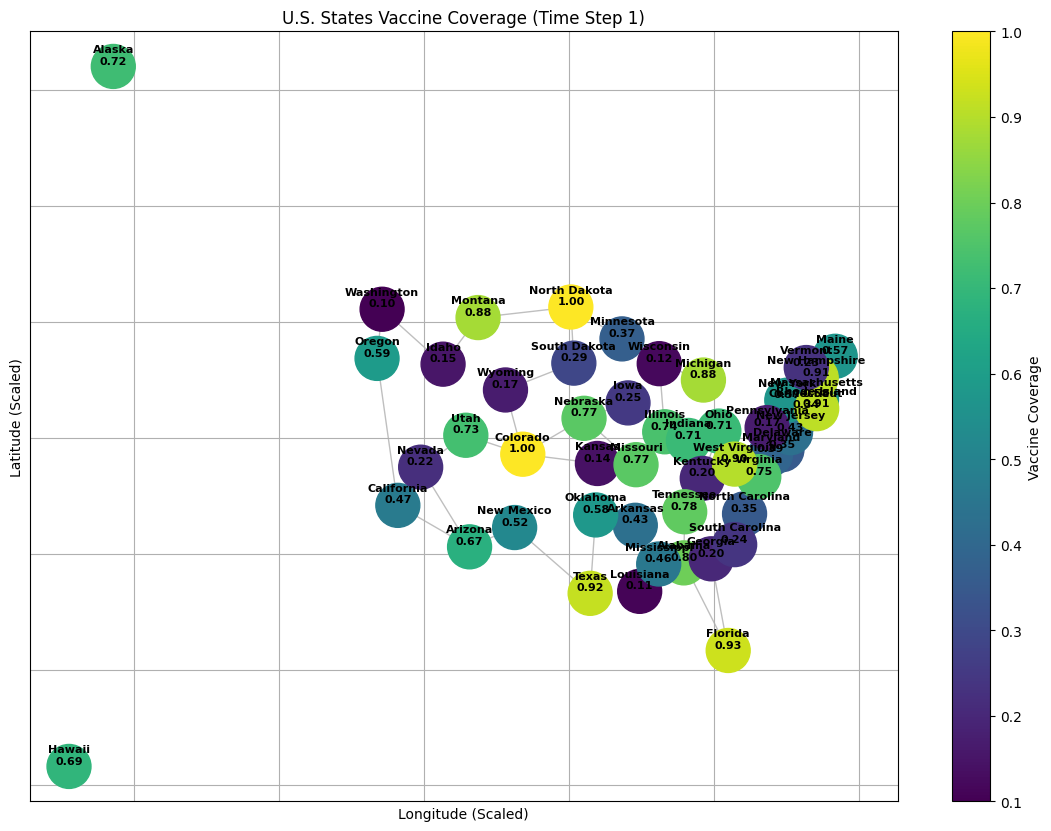


Vaccine Coverage Table (Time Step 1)

         State  Vaccine Coverage
       Alabama              0.80
        Alaska              0.72
       Arizona              0.67
      Arkansas              0.43
    California              0.47
      Colorado              1.00
   Connecticut              0.34
      Delaware              0.35
       Florida              0.93
       Georgia              0.20
        Hawaii              0.69
         Idaho              0.15
      Illinois              0.74
       Indiana              0.71
          Iowa              0.25
        Kansas              0.14
      Kentucky              0.20
     Louisiana              0.11
         Maine              0.57
      Maryland              0.39
 Massachusetts              0.58
      Michigan              0.88
     Minnesota              0.37
   Mississippi              0.46
      Missouri              0.77
       Montana              0.88
      Nebraska              0.77
        Nevada              0.22
 New

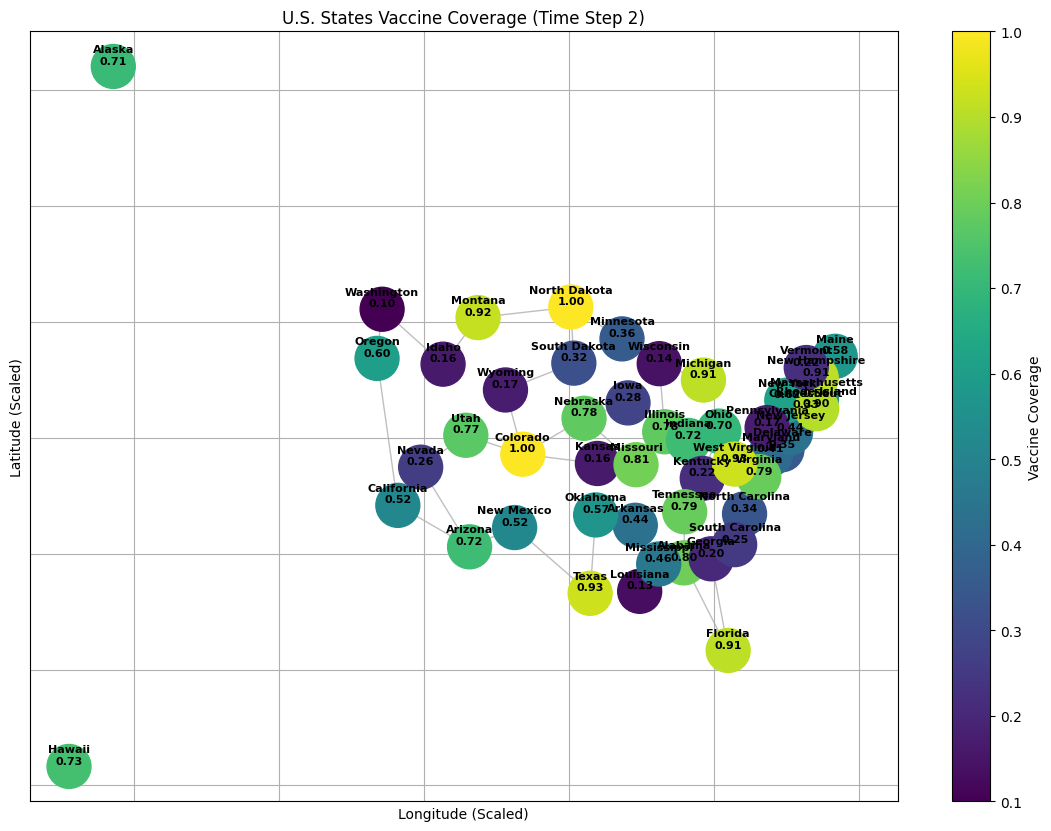


Vaccine Coverage Table (Time Step 2)

         State  Vaccine Coverage
       Alabama              0.80
        Alaska              0.71
       Arizona              0.72
      Arkansas              0.44
    California              0.52
      Colorado              1.00
   Connecticut              0.33
      Delaware              0.35
       Florida              0.91
       Georgia              0.20
        Hawaii              0.73
         Idaho              0.16
      Illinois              0.78
       Indiana              0.72
          Iowa              0.28
        Kansas              0.16
      Kentucky              0.22
     Louisiana              0.13
         Maine              0.58
      Maryland              0.41
 Massachusetts              0.56
      Michigan              0.91
     Minnesota              0.36
   Mississippi              0.46
      Missouri              0.81
       Montana              0.92
      Nebraska              0.78
        Nevada              0.26
 New

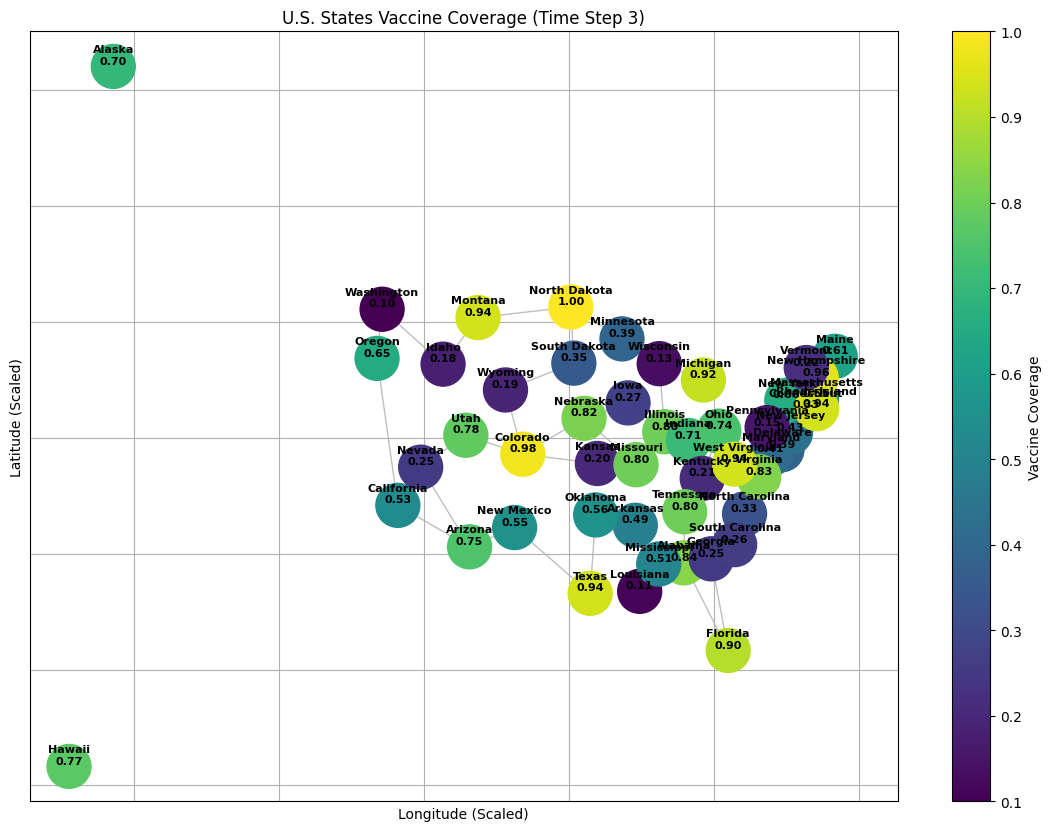


Vaccine Coverage Table (Time Step 3)

         State  Vaccine Coverage
       Alabama              0.84
        Alaska              0.70
       Arizona              0.75
      Arkansas              0.49
    California              0.53
      Colorado              0.98
   Connecticut              0.33
      Delaware              0.39
       Florida              0.90
       Georgia              0.25
        Hawaii              0.77
         Idaho              0.18
      Illinois              0.80
       Indiana              0.71
          Iowa              0.27
        Kansas              0.20
      Kentucky              0.21
     Louisiana              0.11
         Maine              0.61
      Maryland              0.41
 Massachusetts              0.55
      Michigan              0.92
     Minnesota              0.39
   Mississippi              0.51
      Missouri              0.80
       Montana              0.94
      Nebraska              0.82
        Nevada              0.25
 New

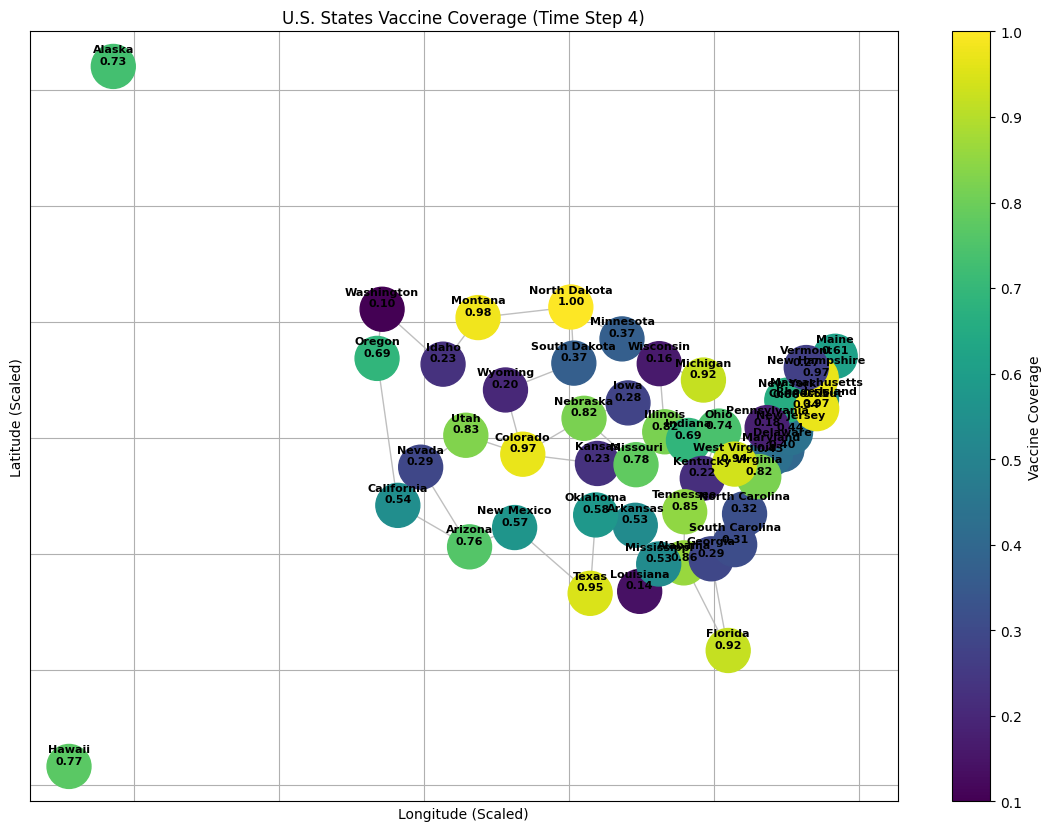


Vaccine Coverage Table (Time Step 4)

         State  Vaccine Coverage
       Alabama              0.86
        Alaska              0.73
       Arizona              0.76
      Arkansas              0.53
    California              0.54
      Colorado              0.97
   Connecticut              0.34
      Delaware              0.40
       Florida              0.92
       Georgia              0.29
        Hawaii              0.77
         Idaho              0.23
      Illinois              0.82
       Indiana              0.69
          Iowa              0.28
        Kansas              0.23
      Kentucky              0.22
     Louisiana              0.14
         Maine              0.61
      Maryland              0.43
 Massachusetts              0.55
      Michigan              0.92
     Minnesota              0.37
   Mississippi              0.53
      Missouri              0.78
       Montana              0.98
      Nebraska              0.82
        Nevada              0.29
 New

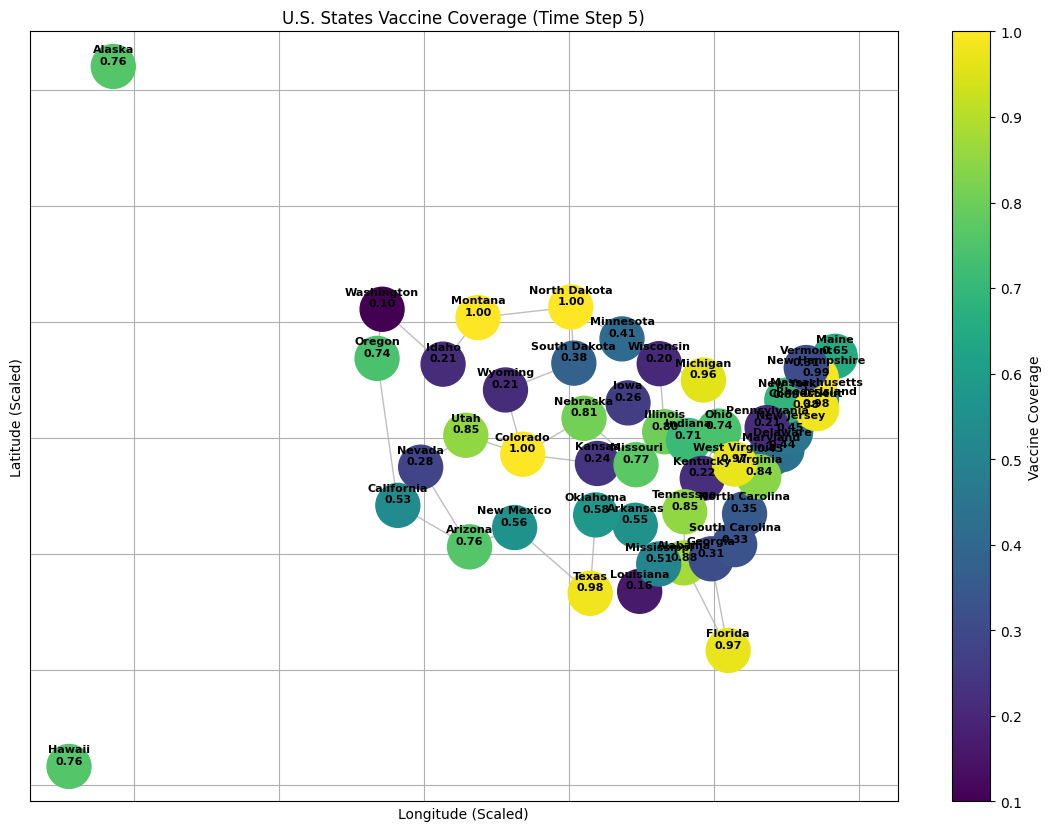


Vaccine Coverage Table (Time Step 5)

         State  Vaccine Coverage
       Alabama              0.88
        Alaska              0.76
       Arizona              0.76
      Arkansas              0.55
    California              0.53
      Colorado              1.00
   Connecticut              0.38
      Delaware              0.44
       Florida              0.97
       Georgia              0.31
        Hawaii              0.76
         Idaho              0.21
      Illinois              0.80
       Indiana              0.71
          Iowa              0.26
        Kansas              0.24
      Kentucky              0.22
     Louisiana              0.16
         Maine              0.65
      Maryland              0.43
 Massachusetts              0.54
      Michigan              0.96
     Minnesota              0.41
   Mississippi              0.51
      Missouri              0.77
       Montana              1.00
      Nebraska              0.81
        Nevada              0.28
 New

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

env = MultiVaccineEnv()
# Define state coordinates (longitude, latitude) and apply scaling to spread out states
scale_factor = 3  # Adjust this value to spread states apart
state_coords = {
    state: (lat * scale_factor, lon * scale_factor)  # Scale latitude and longitude
    for state, (lat, lon) in {
        'Alabama': (32.806671, -86.791130), 'Alaska': (61.370716, -152.404419), 'Arizona': (33.729759, -111.431221),
        'Arkansas': (34.969704, -92.373123), 'California': (36.116203, -119.681564), 'Colorado': (39.059811, -105.311104),
        'Connecticut': (41.597782, -72.755371), 'Delaware': (39.318523, -75.507141), 'Florida': (27.766279, -81.686783),
        'Georgia': (33.040619, -83.643074), 'Hawaii': (21.094318, -157.498337), 'Idaho': (44.240459, -114.478828),
        'Illinois': (40.349457, -88.986137), 'Indiana': (39.849426, -86.258278), 'Iowa': (42.011539, -93.210526),
        'Kansas': (38.526600, -96.726486), 'Kentucky': (37.668140, -84.670067), 'Louisiana': (31.169546, -91.867805),
        'Maine': (44.693947, -69.381927), 'Maryland': (39.063946, -76.802101), 'Massachusetts': (42.230171, -71.530106),
        'Michigan': (43.326618, -84.536095), 'Minnesota': (45.694454, -93.900192), 'Mississippi': (32.741646, -89.678696),
        'Missouri': (38.456085, -92.288368), 'Montana': (46.921925, -110.454353), 'Nebraska': (41.125370, -98.268082),
        'Nevada': (38.313515, -117.055374), 'New Hampshire': (43.452492, -71.563896), 'New Jersey': (40.298904, -74.521011),
        'New Mexico': (34.840515, -106.248482), 'New York': (42.165726, -74.948051), 'North Carolina': (35.630066, -79.806419),
        'North Dakota': (47.528912, -99.784012), 'Ohio': (40.388783, -82.764915), 'Oklahoma': (35.565342, -96.928917),
        'Oregon': (44.572021, -122.070938), 'Pennsylvania': (40.590752, -77.209755), 'Rhode Island': (41.680893, -71.511780),
        'South Carolina': (33.856892, -80.945007), 'South Dakota': (44.299782, -99.438828), 'Tennessee': (35.747845, -86.692345),
        'Texas': (31.054487, -97.563461), 'Utah': (40.150032, -111.862434), 'Vermont': (44.045876, -72.710686),
        'Virginia': (37.769337, -78.169968), 'Washington': (47.400902, -121.490494), 'West Virginia': (38.491226, -80.954456),
        'Wisconsin': (44.268543, -89.616508), 'Wyoming': (42.755966, -107.302490)
    }.items()
}

# Define neighboring states as edges
state_edges = [
    ("Alabama", "Georgia"), ("Alabama", "Tennessee"), ("Alabama", "Mississippi"),
    ("Arizona", "California"), ("Arizona", "Nevada"), ("Arizona", "New Mexico"),
    ("California", "Oregon"), ("California", "Nevada"), ("Colorado", "Utah"),
    ("Colorado", "Kansas"), ("Colorado", "Nebraska"), ("Colorado", "Wyoming"),
    ("Florida", "Georgia"), ("Florida", "Alabama"), ("Georgia", "South Carolina"),
    ("Idaho", "Montana"), ("Idaho", "Washington"), ("Illinois", "Indiana"),
    ("Illinois", "Iowa"), ("Illinois", "Missouri"), ("Indiana", "Ohio"),
    ("Iowa", "Nebraska"), ("Kansas", "Missouri"), ("Kentucky", "Ohio"),
    ("Louisiana", "Mississippi"), ("Maine", "New Hampshire"), ("Maryland", "Pennsylvania"),
    ("Massachusetts", "Rhode Island"), ("Michigan", "Wisconsin"), ("Minnesota", "Wisconsin"),
    ("Missouri", "Nebraska"), ("Montana", "North Dakota"), ("New Mexico", "Texas"),
    ("New York", "New Jersey"), ("North Carolina", "South Carolina"), ("Ohio", "West Virginia"),
    ("Oklahoma", "Texas"), ("Oregon", "Washington"), ("Tennessee", "Kentucky"),
    ("Virginia", "West Virginia"), ("Wyoming", "South Dakota"), ("South Dakota", "North Dakota"),
    ("North Dakota", "Minnesota"), ("Wisconsin", "Illinois"), ("Nevada", "Utah")
]

# Create a graph
G = nx.Graph()
for state, (lat, lon) in state_coords.items():
    G.add_node(state, pos=(lon, lat))
G.add_edges_from(state_edges)

# Initialize vaccine coverage (randomized)
state_vaccine_coverage = {state: round(random.uniform(0.1, 1.0), 2) for state in G.nodes()}

# Function to update vaccine coverage dynamically
def update_vaccine_coverage(state_vaccine_coverage):
    for state in state_vaccine_coverage:
        change = random.uniform(-0.02, 0.05)  # Allow coverage to increase/decrease slightly
        # state_vaccine_coverage[state] = round(max(0, min(1, state_vaccine_coverage[state] + change)), 2)  # Keep in [0,1]
        
    return state_vaccine_coverage

# Visualization loop (run multiple frames to show updates over time)
for step in range(5):  # Number of time steps
    plt.figure(figsize=(14, 10))  # Increase figure size for better visibility
    
    # Update vaccine coverage
    state_vaccine_coverage = update_vaccine_coverage(state_vaccine_coverage)

    # Get node colors based on updated vaccine coverage
    node_colors = [state_vaccine_coverage[state] for state in G.nodes()]
    
    # Get positions
    pos = nx.get_node_attributes(G, 'pos')

    # Draw the graph
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=1000)
    edges = nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)

    # Create labels with state names and vaccine coverage below
    state_labels = {state: f"{state}\n{state_vaccine_coverage[state]:.2f}" for state in G.nodes()}
    
    # Adjust label position to avoid overlap
    label_pos = {state: (coords[0], coords[1] + 2) for state, coords in pos.items()}
    
    # Draw labels (state names and coverage below)
    nx.draw_networkx_labels(G, label_pos, labels=state_labels, font_size=8, font_color="black", font_weight="bold")

    # Add colorbar
    cbar = plt.colorbar(nodes)
    cbar.set_label("Vaccine Coverage")

    plt.title(f"U.S. States Vaccine Coverage (Time Step {step + 1})")
    plt.xlabel("Longitude (Scaled)")
    plt.ylabel("Latitude (Scaled)")
    plt.grid(True)
    plt.show()
    
    # Create a DataFrame that matches the current vaccine coverage values
    df = pd.DataFrame(list(state_vaccine_coverage.items()), columns=["State", "Vaccine Coverage"])
    df = df.sort_values(by="State")  # Sort for consistency
    print(f"\nVaccine Coverage Table (Time Step {step + 1})\n")
    print(df.to_string(index=False))

    time.sleep(1)  # Pause before next update

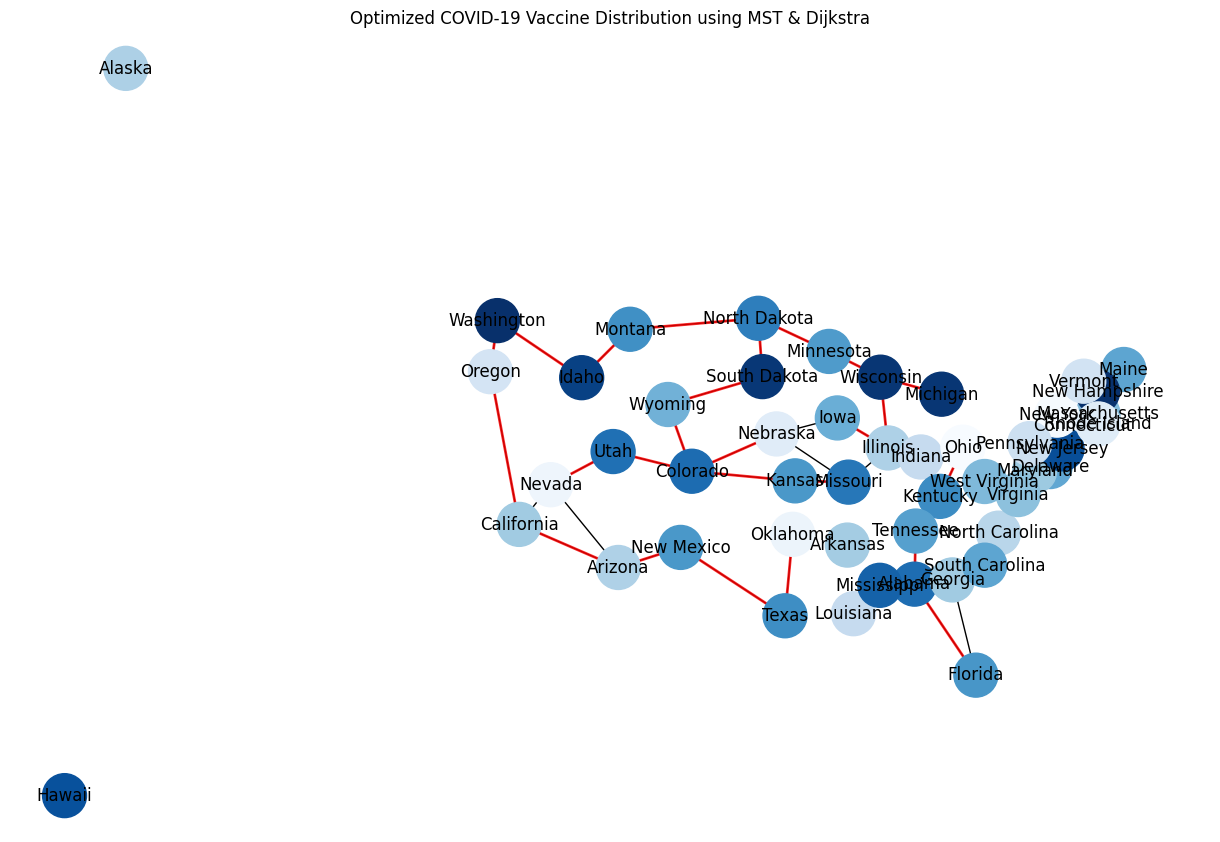

Optimal vaccine route for Alabama: {'Alabama': ['Alabama'], 'Georgia': ['Alabama', 'Georgia'], 'Tennessee': ['Alabama', 'Tennessee'], 'Mississippi': ['Alabama', 'Mississippi'], 'Florida': ['Alabama', 'Florida'], 'Louisiana': ['Alabama', 'Mississippi', 'Louisiana'], 'Kentucky': ['Alabama', 'Tennessee', 'Kentucky'], 'South Carolina': ['Alabama', 'Georgia', 'South Carolina'], 'Ohio': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio'], 'North Carolina': ['Alabama', 'Georgia', 'South Carolina', 'North Carolina'], 'Indiana': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio', 'Indiana'], 'West Virginia': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio', 'West Virginia'], 'Virginia': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio', 'West Virginia', 'Virginia'], 'Illinois': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio', 'Indiana', 'Illinois'], 'Iowa': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio', 'Indiana', 'Illinois', 'Iowa'], 'Missouri': ['Alabama', 'Tennessee', 'Kentucky', 'Ohio', 'Indiana', 'Illinois', 'Missouri']

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import time
# import random

# env = MultiVaccineEnv()

# scale_factor = 3  # Adjust this value to spread states apart
# state_coords = {
#     state: (lat * scale_factor, lon * scale_factor)  # Scale latitude and longitude
#     for state, (lat, lon) in {
#         'Alabama': (32.806671, -86.791130), 'Alaska': (61.370716, -152.404419), 'Arizona': (33.729759, -111.431221),
#         'Arkansas': (34.969704, -92.373123), 'California': (36.116203, -119.681564), 'Colorado': (39.059811, -105.311104),
#         'Connecticut': (41.597782, -72.755371), 'Delaware': (39.318523, -75.507141), 'Florida': (27.766279, -81.686783),
#         'Georgia': (33.040619, -83.643074), 'Hawaii': (21.094318, -157.498337), 'Idaho': (44.240459, -114.478828),
#         'Illinois': (40.349457, -88.986137), 'Indiana': (39.849426, -86.258278), 'Iowa': (42.011539, -93.210526),
#         'Kansas': (38.526600, -96.726486), 'Kentucky': (37.668140, -84.670067), 'Louisiana': (31.169546, -91.867805),
#         'Maine': (44.693947, -69.381927), 'Maryland': (39.063946, -76.802101), 'Massachusetts': (42.230171, -71.530106),
#         'Michigan': (43.326618, -84.536095), 'Minnesota': (45.694454, -93.900192), 'Mississippi': (32.741646, -89.678696),
#         'Missouri': (38.456085, -92.288368), 'Montana': (46.921925, -110.454353), 'Nebraska': (41.125370, -98.268082),
#         'Nevada': (38.313515, -117.055374), 'New Hampshire': (43.452492, -71.563896), 'New Jersey': (40.298904, -74.521011),
#         'New Mexico': (34.840515, -106.248482), 'New York': (42.165726, -74.948051), 'North Carolina': (35.630066, -79.806419),
#         'North Dakota': (47.528912, -99.784012), 'Ohio': (40.388783, -82.764915), 'Oklahoma': (35.565342, -96.928917),
#         'Oregon': (44.572021, -122.070938), 'Pennsylvania': (40.590752, -77.209755), 'Rhode Island': (41.680893, -71.511780),
#         'South Carolina': (33.856892, -80.945007), 'South Dakota': (44.299782, -99.438828), 'Tennessee': (35.747845, -86.692345),
#         'Texas': (31.054487, -97.563461), 'Utah': (40.150032, -111.862434), 'Vermont': (44.045876, -72.710686),
#         'Virginia': (37.769337, -78.169968), 'Washington': (47.400902, -121.490494), 'West Virginia': (38.491226, -80.954456),
#         'Wisconsin': (44.268543, -89.616508), 'Wyoming': (42.755966, -107.302490)
#     }.items()
# }

# # Define neighboring states as edges
# state_edges = [
#     ("Alabama", "Georgia"), ("Alabama", "Tennessee"), ("Alabama", "Mississippi"),
#     ("Arizona", "California"), ("Arizona", "Nevada"), ("Arizona", "New Mexico"),
#     ("California", "Oregon"), ("California", "Nevada"), ("Colorado", "Utah"),
#     ("Colorado", "Kansas"), ("Colorado", "Nebraska"), ("Colorado", "Wyoming"),
#     ("Florida", "Georgia"), ("Florida", "Alabama"), ("Georgia", "South Carolina"),
#     ("Idaho", "Montana"), ("Idaho", "Washington"), ("Illinois", "Indiana"),
#     ("Illinois", "Iowa"), ("Illinois", "Missouri"), ("Indiana", "Ohio"),
#     ("Iowa", "Nebraska"), ("Kansas", "Missouri"), ("Kentucky", "Ohio"),
#     ("Louisiana", "Mississippi"), ("Maine", "New Hampshire"), ("Maryland", "Pennsylvania"),
#     ("Massachusetts", "Rhode Island"), ("Michigan", "Wisconsin"), ("Minnesota", "Wisconsin"),
#     ("Missouri", "Nebraska"), ("Montana", "North Dakota"), ("New Mexico", "Texas"),
#     ("New York", "New Jersey"), ("North Carolina", "South Carolina"), ("Ohio", "West Virginia"),
#     ("Oklahoma", "Texas"), ("Oregon", "Washington"), ("Tennessee", "Kentucky"),
#     ("Virginia", "West Virginia"), ("Wyoming", "South Dakota"), ("South Dakota", "North Dakota"),
#     ("North Dakota", "Minnesota"), ("Wisconsin", "Illinois"), ("Nevada", "Utah")
# ]
# # ✅ Create COVID Vaccine Graph
# G_covid = nx.Graph()
# G_covid.add_nodes_from(state_coords.keys())
# G_covid.add_edges_from(state_edges)

# # ✅ Get COVID vaccine coverage from RL environment
# def get_covid_vaccine_coverage():
#     state_dict = {}
#     for state in G_covid.nodes():
#         state_dict[state] = env.step(random.randint(0, 11))[0][2]  # Get COVID vaccine coverage
#     return state_dict

# # ✅ Assign weights for vaccine distribution (inverse of coverage)
# state_covid_coverage = get_covid_vaccine_coverage()
# for edge in state_edges:
#     state1, state2 = edge
#     weight = 1 / (0.1 + (state_covid_coverage[state1] + state_covid_coverage[state2]) / 2)  # Prevent div-by-zero
#     G_covid.add_edge(state1, state2, weight=weight)

# # ✅ Compute Minimum Spanning Tree (MST)
# mst = nx.minimum_spanning_tree(G_covid, weight='weight')

# # ✅ Find shortest vaccine distribution routes using Dijkstra
# shortest_paths = {}
# for state in G_covid.nodes():
#     shortest_paths[state] = nx.single_source_dijkstra_path(G_covid, state)

# # ✅ Visualization
# plt.figure(figsize=(12, 8))
# pos = {state: (coords[1], coords[0]) for state, coords in state_coords.items()}
# nx.draw(G_covid, pos, with_labels=True, node_color=list(state_covid_coverage.values()), cmap="Blues", node_size=1000)
# nx.draw_networkx_edges(mst, pos, edge_color="red", width=2, alpha=0.8)  # Highlight MST
# plt.title(f"Optimized COVID-19 Vaccine Distribution using MST & Dijkstra")
# plt.show()

# # ✅ Print Distribution Paths
# for state, path in shortest_paths.items():
#     print(f"Optimal vaccine route for {state}: {path}")

# # ✅ Print Table
# df_covid = pd.DataFrame(state_covid_coverage.items(), columns=["State", "COVID Vaccine Coverage"])
# print(df_covid.to_string(index=False))


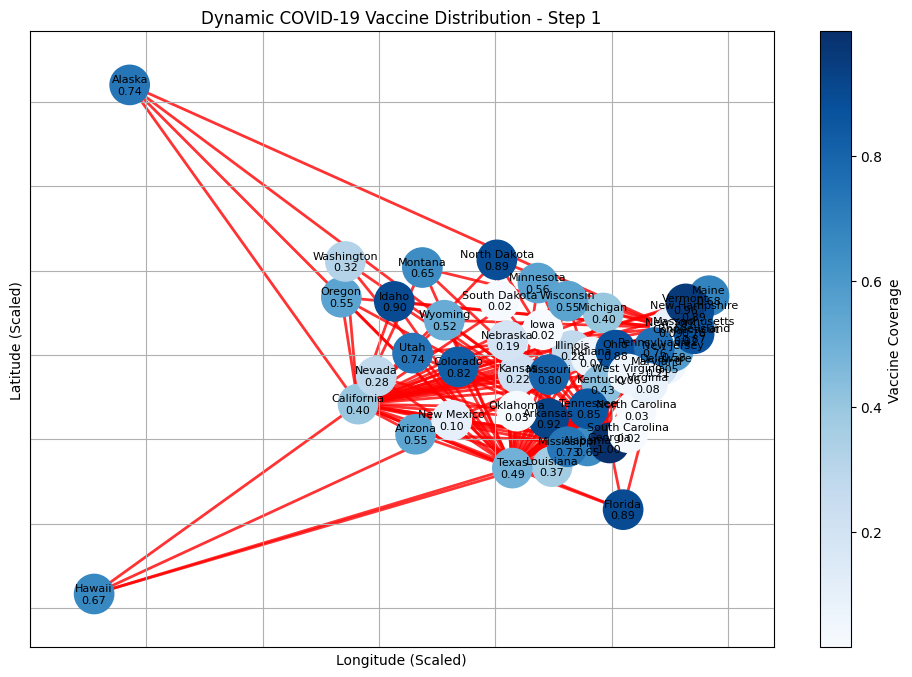


COVID Vaccine Coverage Table - Step 1

         State  COVID Vaccine Coverage
       Alabama                0.646061
        Alaska                0.736079
       Arizona                0.545421
      Arkansas                0.922493
    California                0.397516
      Colorado                0.822676
   Connecticut                0.016421
      Delaware                0.052430
       Florida                0.894713
       Georgia                0.997727
        Hawaii                0.665436
         Idaho                0.897116
      Illinois                0.278174
       Indiana                0.065825
          Iowa                0.016210
        Kansas                0.222425
      Kentucky                0.431851
     Louisiana                0.369862
         Maine                0.683939
      Maryland                0.206602
 Massachusetts                0.758423
      Michigan                0.402111
     Minnesota                0.557037
   Mississippi          

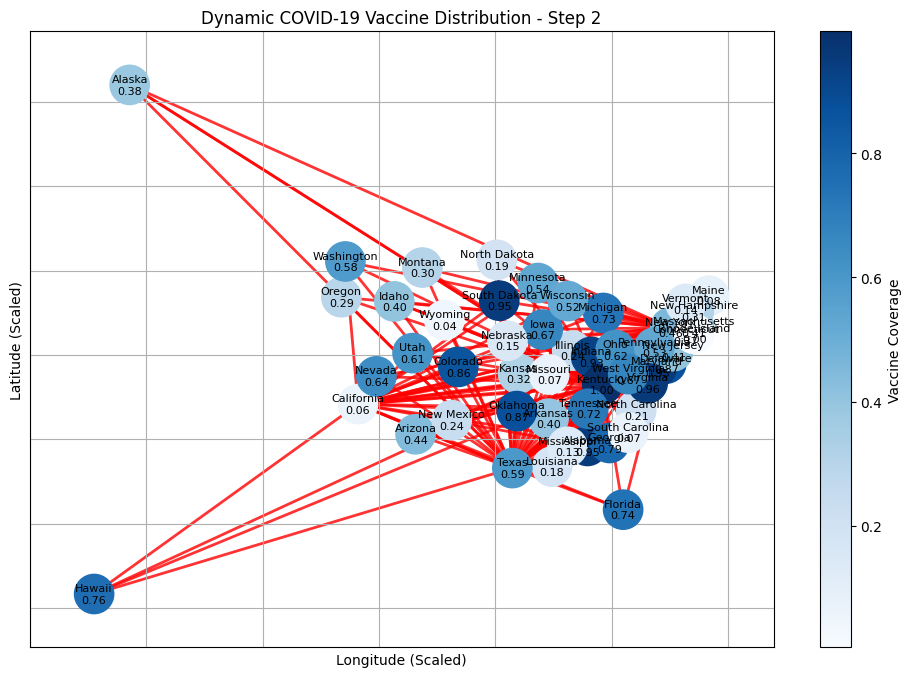


COVID Vaccine Coverage Table - Step 2

         State  COVID Vaccine Coverage
       Alabama                0.950489
        Alaska                0.384440
       Arizona                0.444897
      Arkansas                0.400649
    California                0.062676
      Colorado                0.856665
   Connecticut                0.366138
      Delaware                0.871589
       Florida                0.743196
       Georgia                0.786789
        Hawaii                0.759145
         Idaho                0.404912
      Illinois                0.243482
       Indiana                0.930192
          Iowa                0.668644
        Kansas                0.320957
      Kentucky                0.996537
     Louisiana                0.180131
         Maine                0.081565
      Maryland                0.951617
 Massachusetts                0.409404
      Michigan                0.734162
     Minnesota                0.536969
   Mississippi          

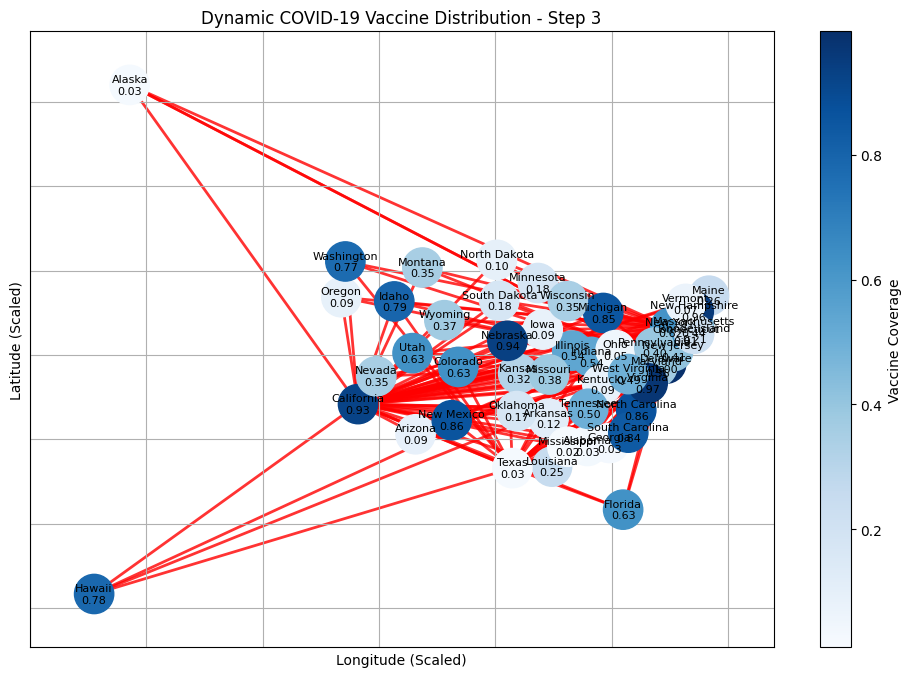


COVID Vaccine Coverage Table - Step 3

         State  COVID Vaccine Coverage
       Alabama                0.034830
        Alaska                0.027520
       Arizona                0.091941
      Arkansas                0.116672
    California                0.927069
      Colorado                0.629471
   Connecticut                0.010853
      Delaware                0.997477
       Florida                0.626419
       Georgia                0.033450
        Hawaii                0.782618
         Idaho                0.793248
      Illinois                0.540996
       Indiana                0.539876
          Iowa                0.087073
        Kansas                0.316780
      Kentucky                0.085773
     Louisiana                0.251112
         Maine                0.255377
      Maryland                0.361920
 Massachusetts                0.442527
      Michigan                0.852413
     Minnesota                0.180493
   Mississippi          

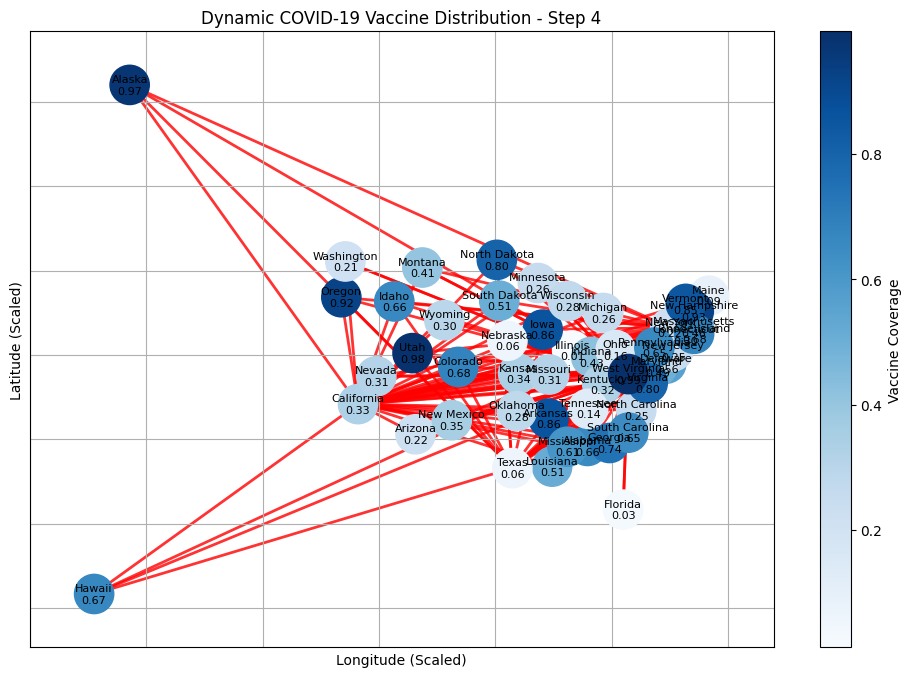


COVID Vaccine Coverage Table - Step 4

         State  COVID Vaccine Coverage
       Alabama                0.656286
        Alaska                0.968864
       Arizona                0.222894
      Arkansas                0.864385
    California                0.334100
      Colorado                0.681781
   Connecticut                0.298444
      Delaware                0.558075
       Florida                0.029988
       Georgia                0.742803
        Hawaii                0.667582
         Idaho                0.661529
      Illinois                0.012796
       Indiana                0.426319
          Iowa                0.860927
        Kansas                0.340755
      Kentucky                0.324698
     Louisiana                0.511783
         Maine                0.087740
      Maryland                0.494214
 Massachusetts                0.459183
      Michigan                0.255636
     Minnesota                0.256804
   Mississippi          

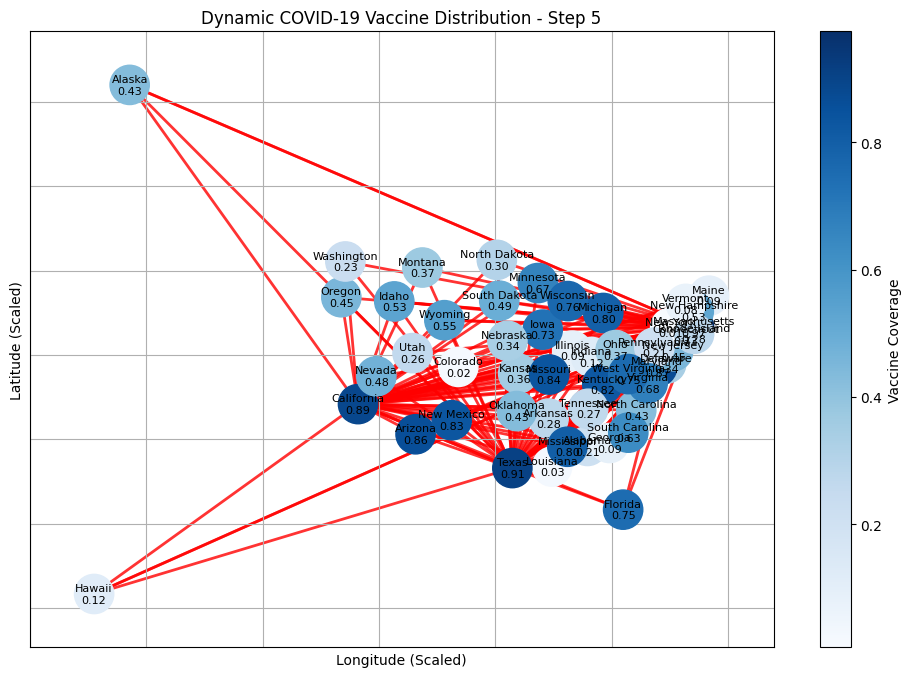


COVID Vaccine Coverage Table - Step 5

         State  COVID Vaccine Coverage
       Alabama                0.211541
        Alaska                0.431649
       Arizona                0.862117
      Arkansas                0.279632
    California                0.890679
      Colorado                0.020751
   Connecticut                0.730393
      Delaware                0.342924
       Florida                0.748549
       Georgia                0.092773
        Hawaii                0.118691
         Idaho                0.534752
      Illinois                0.092554
       Indiana                0.123654
          Iowa                0.727249
        Kansas                0.357364
      Kentucky                0.824297
     Louisiana                0.026766
         Maine                0.094067
      Maryland                0.874166
 Massachusetts                0.974109
      Michigan                0.796326
     Minnesota                0.667684
   Mississippi          

In [131]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

env = MultiVaccineEnv()

# ✅ Scale factor for visibility (Alaska & Hawaii fixed)
scale_factor = 3  # Adjust this value to spread states apart
state_coords = {
    state: (lat * scale_factor, lon * scale_factor)  # Scale latitude and longitude
    for state, (lat, lon) in {
        'Alabama': (32.806671, -86.791130), 'Alaska': (61.370716, -152.404419), 'Arizona': (33.729759, -111.431221),
        'Arkansas': (34.969704, -92.373123), 'California': (36.116203, -119.681564), 'Colorado': (39.059811, -105.311104),
        'Connecticut': (41.597782, -72.755371), 'Delaware': (39.318523, -75.507141), 'Florida': (27.766279, -81.686783),
        'Georgia': (33.040619, -83.643074), 'Hawaii': (21.094318, -157.498337), 'Idaho': (44.240459, -114.478828),
        'Illinois': (40.349457, -88.986137), 'Indiana': (39.849426, -86.258278), 'Iowa': (42.011539, -93.210526),
        'Kansas': (38.526600, -96.726486), 'Kentucky': (37.668140, -84.670067), 'Louisiana': (31.169546, -91.867805),
        'Maine': (44.693947, -69.381927), 'Maryland': (39.063946, -76.802101), 'Massachusetts': (42.230171, -71.530106),
        'Michigan': (43.326618, -84.536095), 'Minnesota': (45.694454, -93.900192), 'Mississippi': (32.741646, -89.678696),
        'Missouri': (38.456085, -92.288368), 'Montana': (46.921925, -110.454353), 'Nebraska': (41.125370, -98.268082),
        'Nevada': (38.313515, -117.055374), 'New Hampshire': (43.452492, -71.563896), 'New Jersey': (40.298904, -74.521011),
        'New Mexico': (34.840515, -106.248482), 'New York': (42.165726, -74.948051), 'North Carolina': (35.630066, -79.806419),
        'North Dakota': (47.528912, -99.784012), 'Ohio': (40.388783, -82.764915), 'Oklahoma': (35.565342, -96.928917),
        'Oregon': (44.572021, -122.070938), 'Pennsylvania': (40.590752, -77.209755), 'Rhode Island': (41.680893, -71.511780),
        'South Carolina': (33.856892, -80.945007), 'South Dakota': (44.299782, -99.438828), 'Tennessee': (35.747845, -86.692345),
        'Texas': (31.054487, -97.563461), 'Utah': (40.150032, -111.862434), 'Vermont': (44.045876, -72.710686),
        'Virginia': (37.769337, -78.169968), 'Washington': (47.400902, -121.490494), 'West Virginia': (38.491226, -80.954456),
        'Wisconsin': (44.268543, -89.616508), 'Wyoming': (42.755966, -107.302490)
    }.items()
}


# ✅ Create a Fully Connected Graph
G_covid = nx.complete_graph(state_coords.keys())

# ✅ Special connections for Alaska and Hawaii (Air & Boat routes)
G_covid.add_edges_from([
    ("Alaska", "Washington"), ("Alaska", "California"),  
    ("Hawaii", "California"), ("Hawaii", "Texas")        
])

# ✅ Function to update vaccine coverage dynamically
def update_vaccine_coverage():
    return {state: env.step(random.randint(0, 11))[0][2] for state in G_covid.nodes()}

# ✅ Function to compute MST and Dijkstra's paths
def compute_optimized_routes():
    # Compute new weights (inverse vaccine coverage)
    for u, v in G_covid.edges():
        weight = 1 / (0.1 + (state_covid_coverage[u] + state_covid_coverage[v]) / 2)
        G_covid[u][v]['weight'] = weight

    # Compute MST (minimum required routes)
    mst = nx.minimum_spanning_tree(G_covid, weight='weight')

    # Compute Dijkstra's shortest paths from major vaccine hubs
    vaccine_hubs = ["California", "Texas", "New York"]
    optimal_routes = set(mst.edges())
    for hub in vaccine_hubs:
        shortest_paths = nx.single_source_dijkstra_path(G_covid, hub, weight='weight')
        for target in shortest_paths:
            path = shortest_paths[target]
            for i in range(len(path) - 1):
                optimal_routes.add((path[i], path[i+1]))

    return optimal_routes

# ✅ Visualization loop (Dynamic Updates)
for step in range(5):  
    plt.figure(figsize=(12, 8))
    
    # ✅ Update vaccine coverage dynamically
    state_covid_coverage = update_vaccine_coverage()

    # ✅ Compute optimal routes (MST + Dijkstra)
    optimal_routes = compute_optimized_routes()

    # ✅ Get positions
    pos = {state: (coords[1], coords[0]) for state, coords in state_coords.items()}

    # ✅ Draw the graph
    node_colors = [state_covid_coverage[state] for state in G_covid.nodes()]
    nodes = nx.draw_networkx_nodes(G_covid, pos, node_color=node_colors, cmap="Blues", node_size=800)
    
    # ✅ Draw only optimal routes
    nx.draw_networkx_edges(G_covid, pos, edgelist=optimal_routes, edge_color="red", width=2, alpha=0.8)
    
    # ✅ Labels with vaccine coverage
    state_labels = {state: f"{state}\n{state_covid_coverage[state]:.2f}" for state in G_covid.nodes()}
    nx.draw_networkx_labels(G_covid, pos, labels=state_labels, font_size=8, font_color="black")

    # ✅ Color bar
    cbar = plt.colorbar(nodes)
    cbar.set_label("Vaccine Coverage")

    plt.title(f"Dynamic COVID-19 Vaccine Distribution - Step {step + 1}")
    plt.xlabel("Longitude (Scaled)")
    plt.ylabel("Latitude (Scaled)")
    plt.grid(True)
    plt.show()

    # ✅ Display Coverage Table
    df_covid = pd.DataFrame(state_covid_coverage.items(), columns=["State", "COVID Vaccine Coverage"])
    print(f"\nCOVID Vaccine Coverage Table - Step {step + 1}\n")
    print(df_covid.to_string(index=False))

    time.sleep(1)  


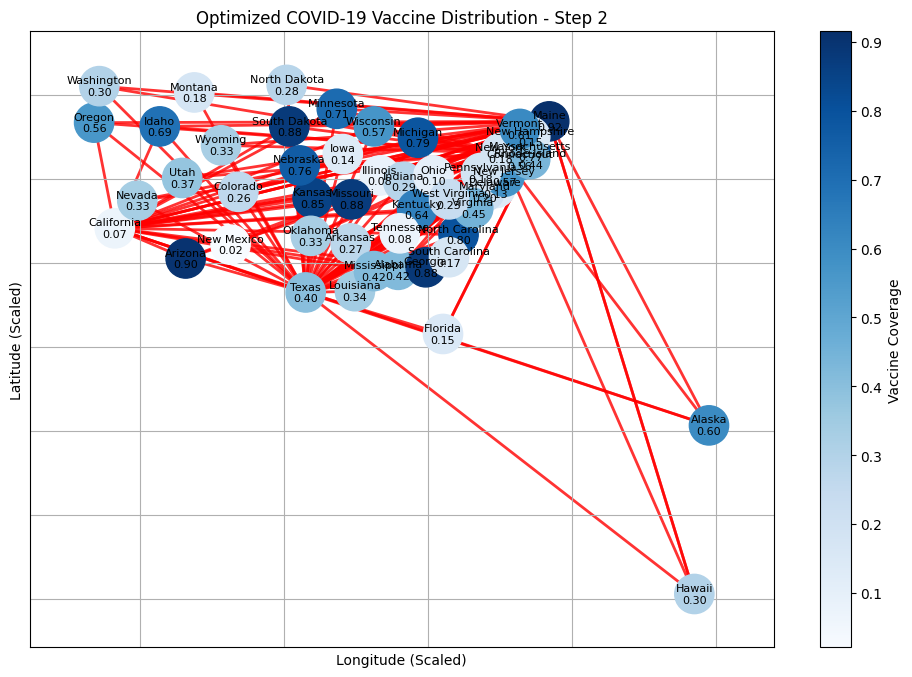

State  COVID Vaccine Coverage
0          Alabama                0.419408
1           Alaska                0.603730
2          Arizona                0.901330
3         Arkansas                0.274508
4       California                0.071357
5         Colorado                0.262438
6      Connecticut                0.555549
7         Delaware                0.132893
8          Florida                0.152688
9          Georgia                0.883754
10          Hawaii                0.301454
11           Idaho                0.688424
12        Illinois                0.082073
13         Indiana                0.286537
14            Iowa                0.136092
15          Kansas                0.854683
16        Kentucky                0.642351
17       Louisiana                0.344104
18           Maine                0.915101
19        Maryland                0.204627
20   Massachusetts                0.774605
21        Michigan                0.787333
22       Minnesota                0.712492
23     Mississippi                0.418498
24        Missouri                0.875750
25         Montana                0.176349
26        Nebraska                0.764218
27          Nevada                0.333658
28   New Hampshire                0.151520
29      New Jersey                0.574561
30      New Mexico                0.020903
31        New York                0.179704
32  North Carolina                0.797193
33    North Dakota                0.284929
34            Ohio                0.103377
35        Oklahoma                0.328581
36          Oregon                0.561115
37    Pennsylvania                0.184202
38    Rhode Island                0.437362
39  South Carolina                0.169154
40    South Dakota                0.877406
41       Tennessee                0.076713
42           Texas                0.404855
43            Utah                0.373783
44         Vermont                0.606569
45        Virginia                0.449337
46      Washington                0.302540
47   West Virginia                0.234917
48       Wisconsin                0.567382
49         Wyoming                0.330438

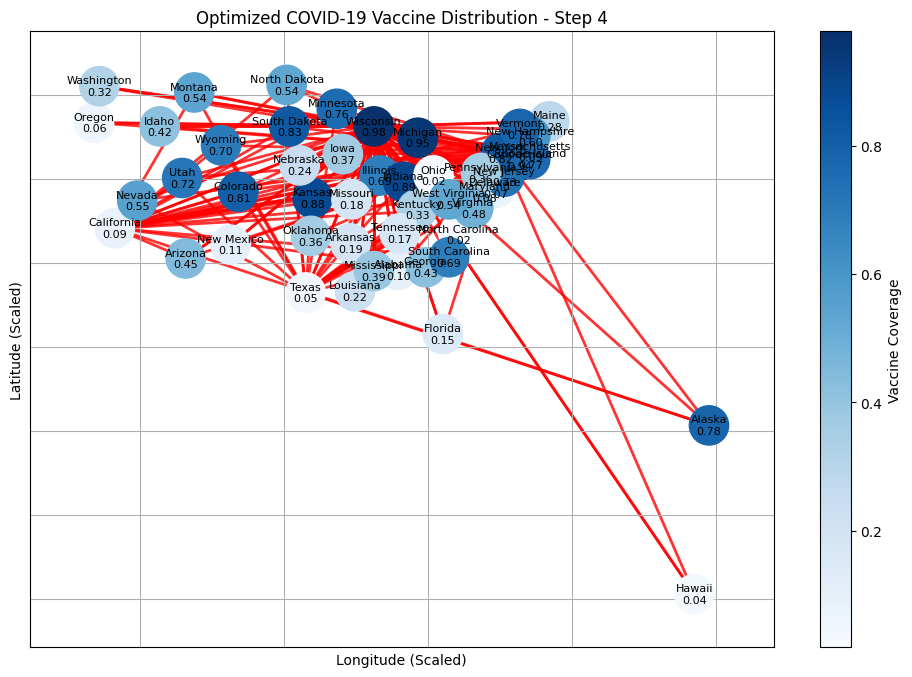

State  COVID Vaccine Coverage
0          Alabama                0.102312
1           Alaska                0.782325
2          Arizona                0.446516
3         Arkansas                0.188135
4       California                0.088673
5         Colorado                0.805630
6      Connecticut                0.938275
7         Delaware                0.071668
8          Florida                0.149596
9          Georgia                0.425188
10          Hawaii                0.038489
11           Idaho                0.416231
12        Illinois                0.691680
13         Indiana                0.894424
14            Iowa                0.365603
15          Kansas                0.882094
16        Kentucky                0.334012
17       Louisiana                0.220582
18           Maine                0.284511
19        Maryland                0.078525
20   Massachusetts                0.090876
21        Michigan                0.949782
22       Minnesota                0.756813
23     Mississippi                0.390660
24        Missouri                0.179660
25         Montana                0.537384
26        Nebraska                0.241225
27          Nevada                0.551897
28   New Hampshire                0.601462
29      New Jersey                0.730829
30      New Mexico                0.109790
31        New York                0.818390
32  North Carolina                0.024959
33    North Dakota                0.535514
34            Ohio                0.017657
35        Oklahoma                0.362392
36          Oregon                0.061339
37    Pennsylvania                0.360860
38    Rhode Island                0.765852
39  South Carolina                0.690591
40    South Dakota                0.827155
41       Tennessee                0.171754
42           Texas                0.045147
43            Utah                0.718819
44         Vermont                0.779054
45        Virginia                0.483886
46      Washington                0.320368
47   West Virginia                0.535373
48       Wisconsin                0.978400
49         Wyoming                0.702355

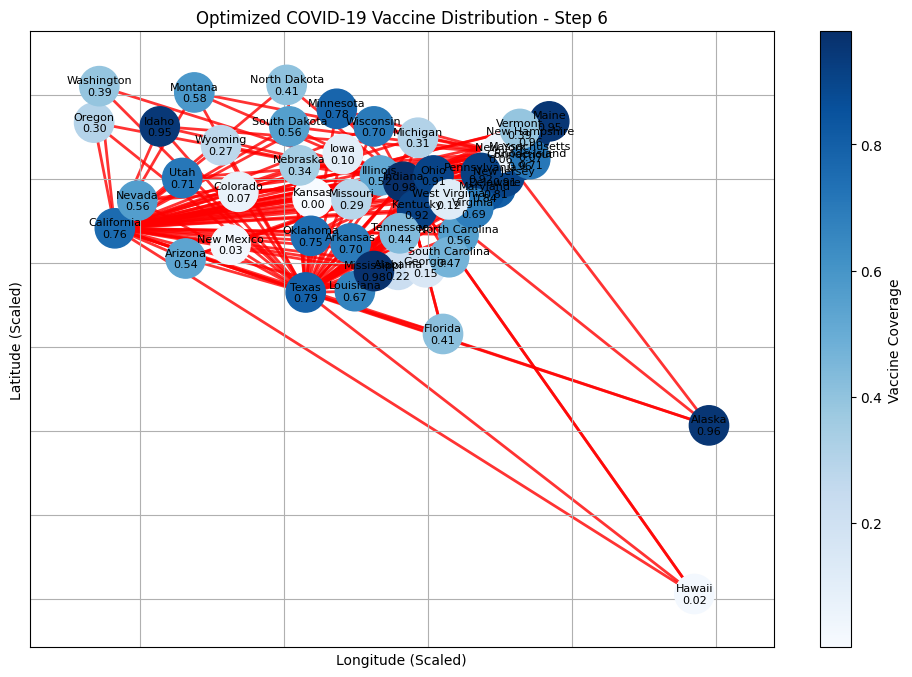

State  COVID Vaccine Coverage
0          Alabama                0.221000
1           Alaska                0.956295
2          Arizona                0.535155
3         Arkansas                0.697155
4       California                0.757592
5         Colorado                0.072815
6      Connecticut                0.963898
7         Delaware                0.806744
8          Florida                0.410800
9          Georgia                0.152852
10          Hawaii                0.021612
11           Idaho                0.946946
12        Illinois                0.522590
13         Indiana                0.979272
14            Iowa                0.103460
15          Kansas                0.002354
16        Kentucky                0.915629
17       Louisiana                0.669015
18           Maine                0.954481
19        Maryland                0.843217
20   Massachusetts                0.074280
21        Michigan                0.308409
22       Minnesota                0.777642
23     Mississippi                0.975040
24        Missouri                0.287267
25         Montana                0.583574
26        Nebraska                0.344457
27          Nevada                0.560628
28   New Hampshire                0.955948
29      New Jersey                0.908545
30      New Mexico                0.032585
31        New York                0.056004
32  North Carolina                0.558559
33    North Dakota                0.406115
34            Ohio                0.909220
35        Oklahoma                0.745659
36          Oregon                0.303049
37    Pennsylvania                0.919722
38    Rhode Island                0.709993
39  South Carolina                0.471344
40    South Dakota                0.557909
41       Tennessee                0.440664
42           Texas                0.794518
43            Utah                0.711011
44         Vermont                0.388633
45        Virginia                0.687485
46      Washington                0.390349
47   West Virginia                0.118648
48       Wisconsin                0.702310
49         Wyoming                0.274275

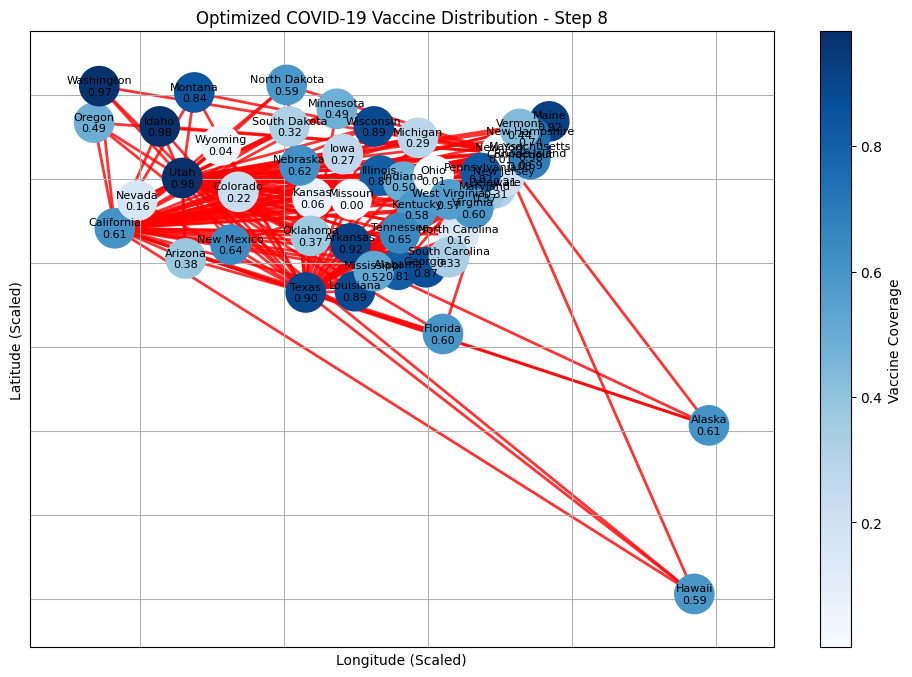

State  COVID Vaccine Coverage
0          Alabama                0.812705
1           Alaska                0.607205
2          Arizona                0.383105
3         Arkansas                0.918230
4       California                0.608060
5         Colorado                0.224337
6      Connecticut                0.082182
7         Delaware                0.308982
8          Florida                0.598614
9          Georgia                0.870981
10          Hawaii                0.592027
11           Idaho                0.981917
12        Illinois                0.804732
13         Indiana                0.497490
14            Iowa                0.267293
15          Kansas                0.063905
16        Kentucky                0.584686
17       Louisiana                0.886337
18           Maine                0.924005
19        Maryland                0.374564
20   Massachusetts                0.979048
21        Michigan                0.288423
22       Minnesota                0.487164
23     Mississippi                0.522702
24        Missouri                0.000802
25         Montana                0.840338
26        Nebraska                0.617737
27          Nevada                0.158102
28   New Hampshire                0.744994
29      New Jersey                0.213369
30      New Mexico                0.637511
31        New York                0.014052
32  North Carolina                0.155635
33    North Dakota                0.587649
34            Ohio                0.008921
35        Oklahoma                0.372085
36          Oregon                0.490811
37    Pennsylvania                0.822989
38    Rhode Island                0.686273
39  South Carolina                0.333453
40    South Dakota                0.321527
41       Tennessee                0.647432
42           Texas                0.898542
43            Utah                0.982681
44         Vermont                0.441374
45        Virginia                0.596617
46      Washington                0.972311
47   West Virginia                0.568155
48       Wisconsin                0.890237
49         Wyoming                0.037593

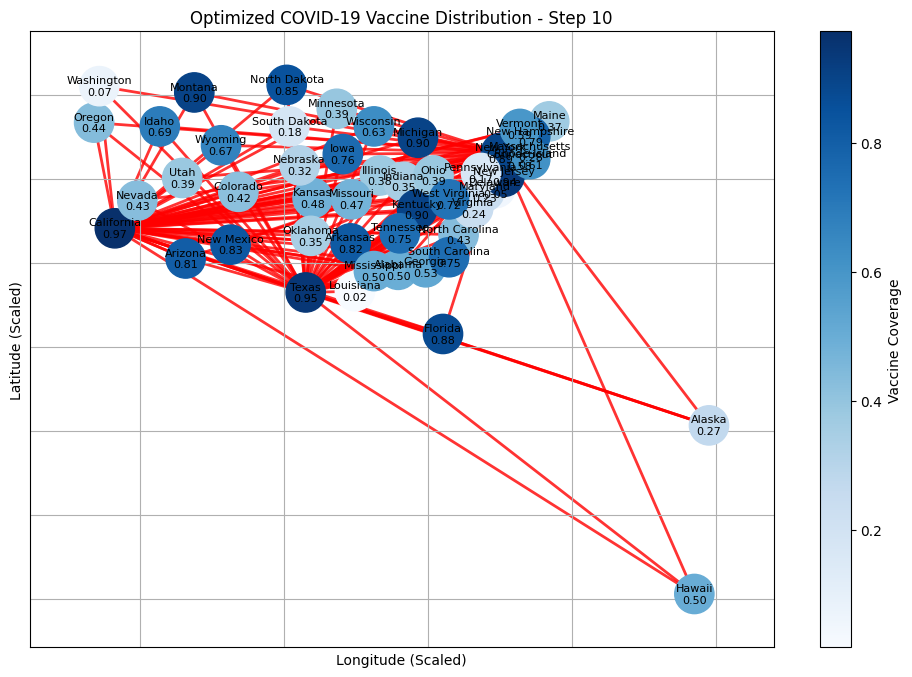

State  COVID Vaccine Coverage
0          Alabama                0.495267
1           Alaska                0.268202
2          Arizona                0.807361
3         Arkansas                0.817221
4       California                0.972878
5         Colorado                0.420074
6      Connecticut                0.576978
7         Delaware                0.052391
8          Florida                0.878296
9          Georgia                0.528194
10          Hawaii                0.503960
11           Idaho                0.694811
12        Illinois                0.375713
13         Indiana                0.348922
14            Iowa                0.758157
15          Kansas                0.481693
16        Kentucky                0.902982
17       Louisiana                0.017017
18           Maine                0.369934
19        Maryland                0.234797
20   Massachusetts                0.280836
21        Michigan                0.903381
22       Minnesota                0.392207
23     Mississippi                0.503618
24        Missouri                0.473359
25         Montana                0.903656
26        Nebraska                0.316256
27          Nevada                0.429726
28   New Hampshire                0.789307
29      New Jersey                0.941534
30      New Mexico                0.829297
31        New York                0.892002
32  North Carolina                0.431646
33    North Dakota                0.847512
34            Ohio                0.385940
35        Oklahoma                0.346591
36          Oregon                0.437969
37    Pennsylvania                0.169934
38    Rhode Island                0.611677
39  South Carolina                0.747808
40    South Dakota                0.184841
41       Tennessee                0.745445
42           Texas                0.945217
43            Utah                0.385027
44         Vermont                0.593607
45        Virginia                0.243658
46      Washington                0.074864
47   West Virginia                0.722935
48       Wisconsin                0.630067
49         Wyoming                0.671779

In [ ]:
# Re-import necessary libraries after execution state reset
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Initialize the MultiVaccine Environment
env = MultiVaccineEnv()

# Scale factor for visibility (Alaska & Hawaii fixed)
scale_factor = 3  # Adjust this value to spread states apart
state_coords = {
    state: (lat * scale_factor, lon * scale_factor) if state not in ["Alaska", "Hawaii"] else (lat, lon)
    for state, (lat, lon) in {
        'Alabama': (32.8, -86.8), 'Alaska': (61.3, -152.4), 'Arizona': (33.7, -111.4),
        'Arkansas': (34.9, -92.3), 'California': (36.1, -119.6), 'Colorado': (39.0, -105.3),
        'Connecticut': (41.5, -72.7), 'Delaware': (39.3, -75.5), 'Florida': (27.7, -81.6),
        'Georgia': (33.0, -83.6), 'Hawaii': (21.09, -157.49), 'Idaho': (44.2, -114.4),
        'Illinois': (40.3, -88.9), 'Indiana': (39.8, -86.2), 'Iowa': (42.0, -93.2),
        'Kansas': (38.5, -96.7), 'Kentucky': (37.6, -84.6), 'Louisiana': (31.1, -91.8),
        'Maine': (44.6, -69.3), 'Maryland': (39.0, -76.8), 'Massachusetts': (42.2, -71.5),
        'Michigan': (43.3, -84.5), 'Minnesota': (45.6, -93.9), 'Mississippi': (32.7, -89.6),
        'Missouri': (38.4, -92.2), 'Montana': (46.9, -110.4), 'Nebraska': (41.1, -98.2),
        'Nevada': (38.3, -117.0), 'New Hampshire': (43.4, -71.5), 'New Jersey': (40.2, -74.5),
        'New Mexico': (34.8, -106.2), 'New York': (42.1, -74.9), 'North Carolina': (35.6, -79.8),
        'North Dakota': (47.5, -99.7), 'Ohio': (40.3, -82.7), 'Oklahoma': (35.5, -96.9),
        'Oregon': (44.5, -122.0), 'Pennsylvania': (40.5, -77.2), 'Rhode Island': (41.6, -71.5),
        'South Carolina': (33.8, -80.9), 'South Dakota': (44.2, -99.4), 'Tennessee': (35.7, -86.6),
        'Texas': (31.0, -97.5), 'Utah': (40.1, -111.8), 'Vermont': (44.0, -72.7),
        'Virginia': (37.7, -78.1), 'Washington': (47.4, -121.4), 'West Virginia': (38.4, -80.9),
        'Wisconsin': (44.2, -89.6), 'Wyoming': (42.7, -107.3)
    }.items()
}

# Create a Fully Connected Graph
G_covid = nx.complete_graph(state_coords.keys())

# Special connections for Alaska and Hawaii (Air & Boat routes)
G_covid.add_edges_from([
    ("Alaska", "Washington"), ("Alaska", "California"),  
    ("Hawaii", "California"), ("Hawaii", "Texas")        
])

# Function to update vaccine coverage dynamically
def update_vaccine_coverage():
    return {state: env.step(random.randint(0, 11))[0][2] for state in G_covid.nodes()}

# Function to compute MST and Dijkstra's paths
def compute_optimized_routes():
    # Compute new weights (inverse vaccine coverage)
    for u, v in G_covid.edges():
        weight = 1 / (0.1 + (state_covid_coverage[u] + state_covid_coverage[v]) / 2)
        G_covid[u][v]['weight'] = weight

    # Compute MST (minimum required routes)
    mst = nx.minimum_spanning_tree(G_covid, weight='weight')

    # Compute Dijkstra's shortest paths from major vaccine hubs
    vaccine_hubs = ["California", "Texas", "New York"]
    optimal_routes = set(mst.edges())
    for hub in vaccine_hubs:
        shortest_paths = nx.single_source_dijkstra_path(G_covid, hub, weight='weight')
        for target in shortest_paths:
            path = shortest_paths[target]
            for i in range(len(path) - 1):
                optimal_routes.add((path[i], path[i+1]))

    return optimal_routes

# Run the simulation until optimal routes remain
best_results = []
max_steps = 100

for step in range(max_steps):
    # Update vaccine coverage dynamically
    state_covid_coverage = update_vaccine_coverage()

    # Compute optimal routes (MST + Dijkstra)
    optimal_routes = compute_optimized_routes()

    # Store the best 4 intermediate results
    if step in [1, 3, 5, 7] or step == max_steps - 1:
        best_results.append((step, optimal_routes.copy(), state_covid_coverage.copy()))

# Display the best 4 results + final result
for step, optimal_routes, state_covid_coverage in best_results:
    plt.figure(figsize=(12, 8))
    
    # Get positions
    pos = {state: (coords[1], coords[0]) for state, coords in state_coords.items()}

    # Draw the graph
    node_colors = [state_covid_coverage[state] for state in G_covid.nodes()]
    nodes = nx.draw_networkx_nodes(G_covid, pos, node_color=node_colors, cmap="Blues", node_size=800)
    
    # Draw only optimal routes
    nx.draw_networkx_edges(G_covid, pos, edgelist=optimal_routes, edge_color="red", width=2, alpha=0.8)
    
    # Labels with vaccine coverage
    state_labels = {state: f"{state}\n{state_covid_coverage[state]:.2f}" for state in G_covid.nodes()}
    nx.draw_networkx_labels(G_covid, pos, labels=state_labels, font_size=8, font_color="black")

    # Color bar
    cbar = plt.colorbar(nodes)
    cbar.set_label("Vaccine Coverage")

    plt.title(f"Optimized COVID-19 Vaccine Distribution - Step {step + 1}")
    plt.xlabel("Longitude (Scaled)")
    plt.ylabel("Latitude (Scaled)")
    plt.grid(True)
    plt.show()

    # Display Coverage Table
    df_covid = pd.DataFrame(state_covid_coverage.items(), columns=["State", "COVID Vaccine Coverage"])
    display(df_covid)


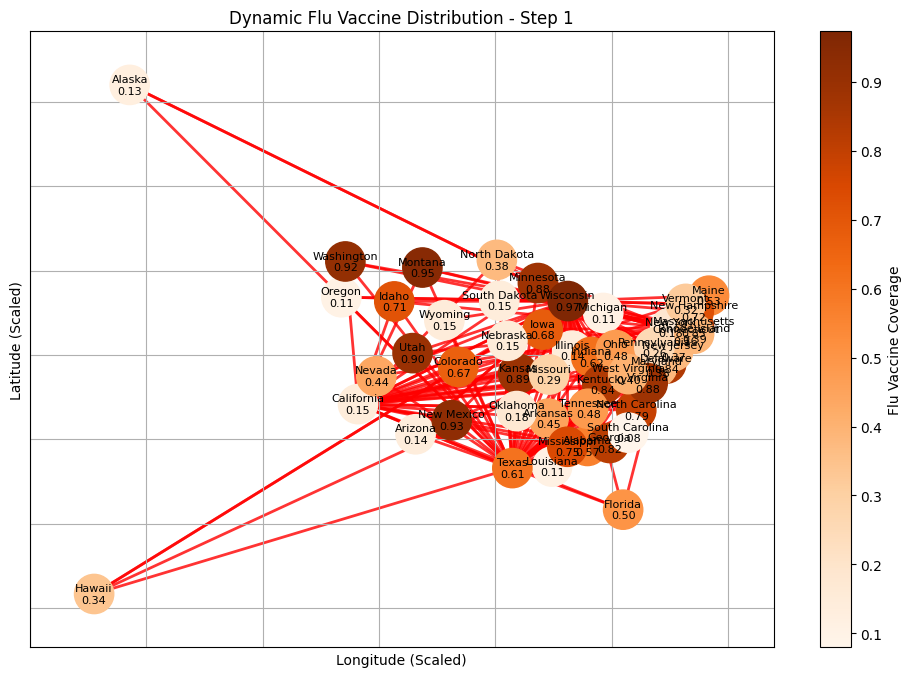


Flu Vaccine Coverage Table - Step 1

         State  Flu Vaccine Coverage
       Alabama              0.566329
        Alaska              0.127462
       Arizona              0.136165
      Arkansas              0.452058
    California              0.145064
      Colorado              0.669088
   Connecticut              0.163452
      Delaware              0.837544
       Florida              0.503278
       Georgia              0.818252
        Hawaii              0.340754
         Idaho              0.713469
      Illinois              0.144243
       Indiana              0.616488
          Iowa              0.683283
        Kansas              0.892328
      Kentucky              0.837178
     Louisiana              0.113384
         Maine              0.533280
      Maryland              0.376868
 Massachusetts              0.850995
      Michigan              0.108569
     Minnesota              0.880412
   Mississippi              0.745572
      Missouri              0.290075


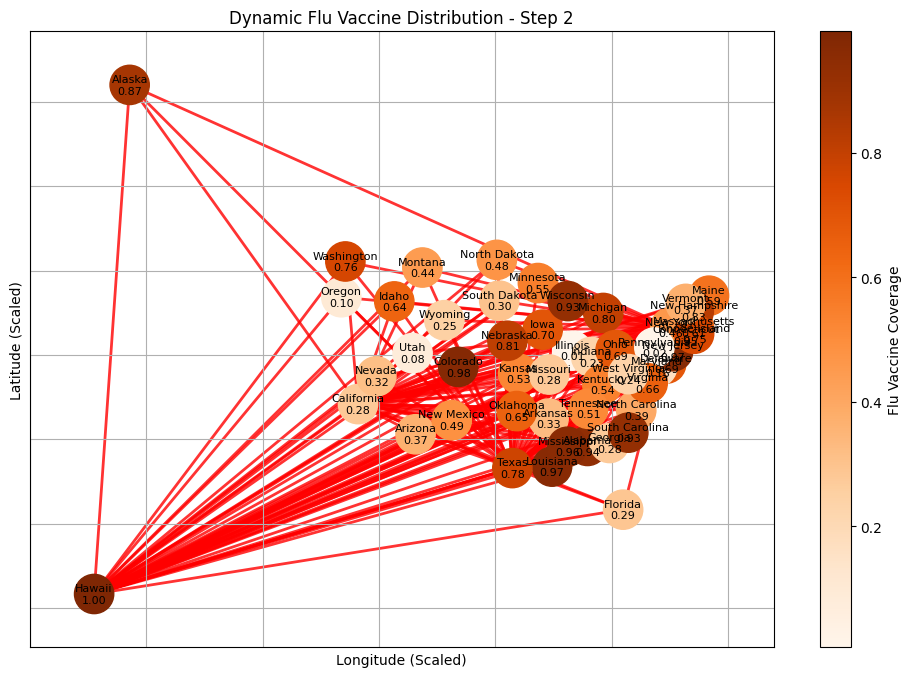


Flu Vaccine Coverage Table - Step 2

         State  Flu Vaccine Coverage
       Alabama              0.939522
        Alaska              0.870189
       Arizona              0.367878
      Arkansas              0.326487
    California              0.278048
      Colorado              0.975494
   Connecticut              0.953134
      Delaware              0.691599
       Florida              0.288176
       Georgia              0.275187
        Hawaii              0.995350
         Idaho              0.640910
      Illinois              0.005125
       Indiana              0.232463
          Iowa              0.698498
        Kansas              0.525527
      Kentucky              0.539752
     Louisiana              0.967877
         Maine              0.590339
      Maryland              0.162041
 Massachusetts              0.605881
      Michigan              0.799472
     Minnesota              0.549741
   Mississippi              0.956806
      Missouri              0.279638


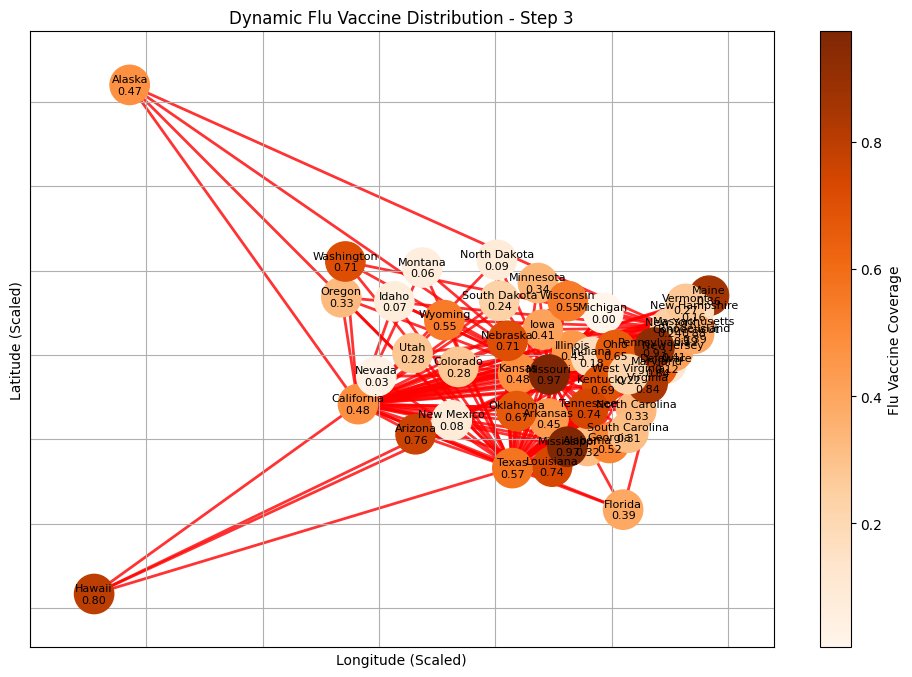


Flu Vaccine Coverage Table - Step 3

         State  Flu Vaccine Coverage
       Alabama              0.316882
        Alaska              0.474816
       Arizona              0.764691
      Arkansas              0.445783
    California              0.479384
      Colorado              0.279429
   Connecticut              0.194551
      Delaware              0.119348
       Florida              0.390261
       Georgia              0.519194
        Hawaii              0.798309
         Idaho              0.072708
      Illinois              0.452241
       Indiana              0.175706
          Iowa              0.412199
        Kansas              0.484363
      Kentucky              0.694089
     Louisiana              0.736300
         Maine              0.863315
      Maryland              0.641233
 Massachusetts              0.884856
      Michigan              0.004526
     Minnesota              0.342147
   Mississippi              0.969505
      Missouri              0.973911


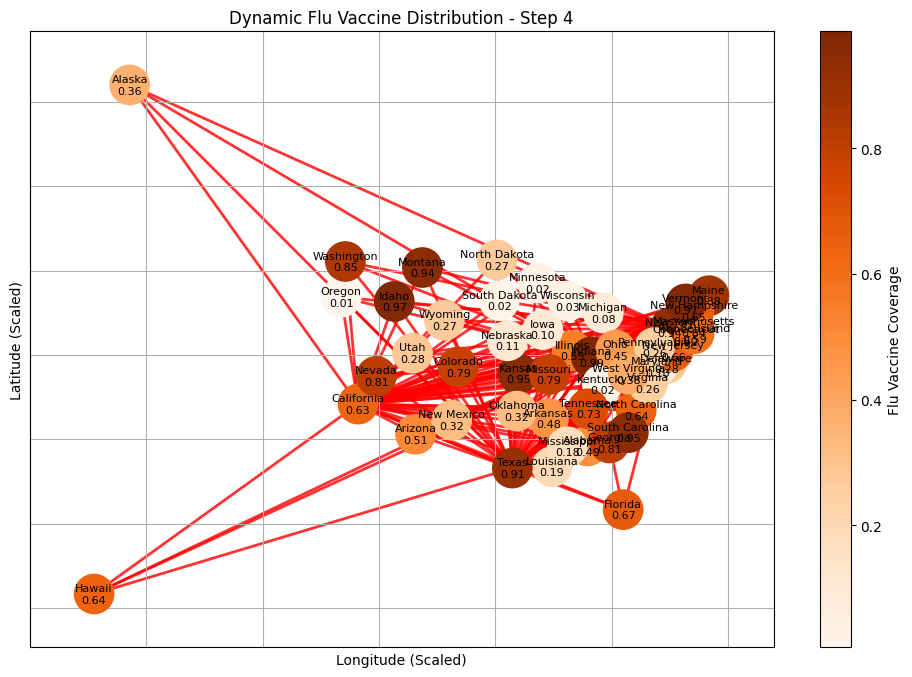


Flu Vaccine Coverage Table - Step 4

         State  Flu Vaccine Coverage
       Alabama              0.489618
        Alaska              0.362471
       Arizona              0.507959
      Arkansas              0.475156
    California              0.629938
      Colorado              0.790381
   Connecticut              0.602673
      Delaware              0.277901
       Florida              0.667952
       Georgia              0.807688
        Hawaii              0.639976
         Idaho              0.974617
      Illinois              0.553015
       Indiana              0.985990
          Iowa              0.099714
        Kansas              0.953105
      Kentucky              0.020610
     Louisiana              0.194716
         Maine              0.878603
      Maryland              0.102882
 Massachusetts              0.837461
      Michigan              0.083051
     Minnesota              0.024360
   Mississippi              0.177009
      Missouri              0.794172


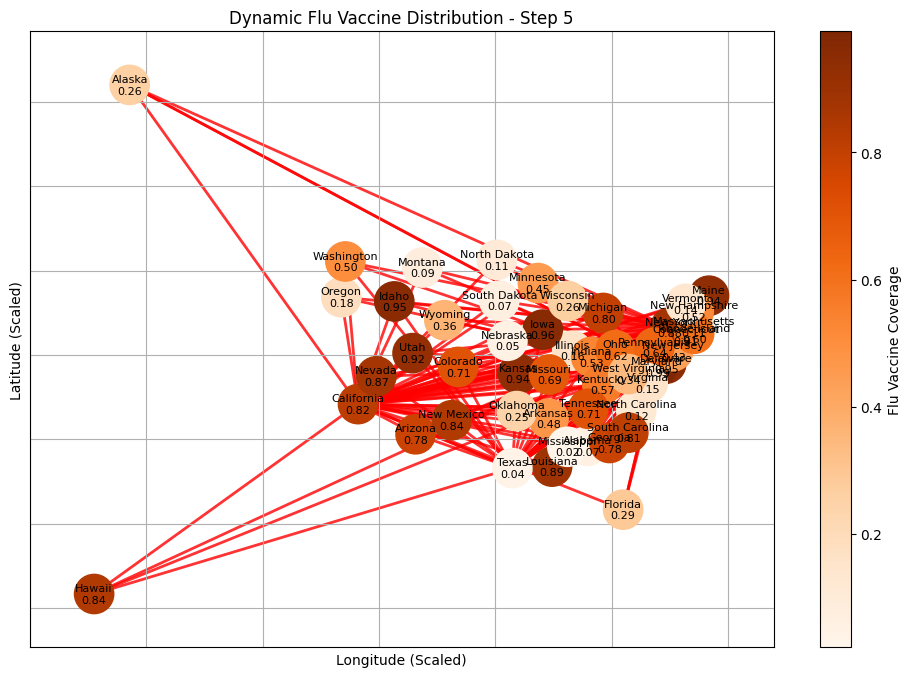


Flu Vaccine Coverage Table - Step 5

         State  Flu Vaccine Coverage
       Alabama              0.065656
        Alaska              0.259095
       Arizona              0.782111
      Arkansas              0.475456
    California              0.817493
      Colorado              0.710315
   Connecticut              0.906689
      Delaware              0.950329
       Florida              0.288764
       Georgia              0.782215
        Hawaii              0.840635
         Idaho              0.953179
      Illinois              0.158799
       Indiana              0.533706
          Iowa              0.960813
        Kansas              0.941024
      Kentucky              0.566218
     Louisiana              0.890647
         Maine              0.938305
      Maryland              0.990500
 Massachusetts              0.113858
      Michigan              0.799913
     Minnesota              0.451265
   Mississippi              0.021106
      Missouri              0.690339


In [132]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

env = MultiVaccineEnv()

# ✅ Scale factor for visibility (Alaska & Hawaii fixed)
scale_factor = 3  # Adjust this value to spread states apart
state_coords = {
    state: (lat * scale_factor, lon * scale_factor)  # Scale latitude and longitude
    for state, (lat, lon) in {
        'Alabama': (32.806671, -86.791130), 'Alaska': (61.370716, -152.404419), 'Arizona': (33.729759, -111.431221),
        'Arkansas': (34.969704, -92.373123), 'California': (36.116203, -119.681564), 'Colorado': (39.059811, -105.311104),
        'Connecticut': (41.597782, -72.755371), 'Delaware': (39.318523, -75.507141), 'Florida': (27.766279, -81.686783),
        'Georgia': (33.040619, -83.643074), 'Hawaii': (21.094318, -157.498337), 'Idaho': (44.240459, -114.478828),
        'Illinois': (40.349457, -88.986137), 'Indiana': (39.849426, -86.258278), 'Iowa': (42.011539, -93.210526),
        'Kansas': (38.526600, -96.726486), 'Kentucky': (37.668140, -84.670067), 'Louisiana': (31.169546, -91.867805),
        'Maine': (44.693947, -69.381927), 'Maryland': (39.063946, -76.802101), 'Massachusetts': (42.230171, -71.530106),
        'Michigan': (43.326618, -84.536095), 'Minnesota': (45.694454, -93.900192), 'Mississippi': (32.741646, -89.678696),
        'Missouri': (38.456085, -92.288368), 'Montana': (46.921925, -110.454353), 'Nebraska': (41.125370, -98.268082),
        'Nevada': (38.313515, -117.055374), 'New Hampshire': (43.452492, -71.563896), 'New Jersey': (40.298904, -74.521011),
        'New Mexico': (34.840515, -106.248482), 'New York': (42.165726, -74.948051), 'North Carolina': (35.630066, -79.806419),
        'North Dakota': (47.528912, -99.784012), 'Ohio': (40.388783, -82.764915), 'Oklahoma': (35.565342, -96.928917),
        'Oregon': (44.572021, -122.070938), 'Pennsylvania': (40.590752, -77.209755), 'Rhode Island': (41.680893, -71.511780),
        'South Carolina': (33.856892, -80.945007), 'South Dakota': (44.299782, -99.438828), 'Tennessee': (35.747845, -86.692345),
        'Texas': (31.054487, -97.563461), 'Utah': (40.150032, -111.862434), 'Vermont': (44.045876, -72.710686),
        'Virginia': (37.769337, -78.169968), 'Washington': (47.400902, -121.490494), 'West Virginia': (38.491226, -80.954456),
        'Wisconsin': (44.268543, -89.616508), 'Wyoming': (42.755966, -107.302490)
    }.items()
}

# ✅ Create a Fully Connected Graph
G_flu = nx.complete_graph(state_coords.keys())

# ✅ Special connections for Alaska and Hawaii (Air & Boat routes)
G_flu.add_edges_from([
    ("Alaska", "Washington"), ("Alaska", "California"),  
    ("Hawaii", "California"), ("Hawaii", "Texas")        
])

# ✅ Function to update flu vaccine coverage dynamically
def update_flu_vaccine_coverage():
    return {state: env.step(random.randint(0, 11))[0][env.flu_env.state_size + 2] for state in G_flu.nodes()}

# ✅ Function to compute MST and Dijkstra's paths
def compute_flu_optimized_routes():
    # Compute new weights (inverse vaccine coverage)
    for u, v in G_flu.edges():
        weight = 1 / (0.1 + (state_flu_coverage[u] + state_flu_coverage[v]) / 2)
        G_flu[u][v]['weight'] = weight

    # Compute MST (minimum required routes)
    mst = nx.minimum_spanning_tree(G_flu, weight='weight')

    # Compute Dijkstra's shortest paths from major vaccine hubs
    vaccine_hubs = ["California", "Texas", "New York"]
    optimal_routes = set(mst.edges())
    for hub in vaccine_hubs:
        shortest_paths = nx.single_source_dijkstra_path(G_flu, hub, weight='weight')
        for target in shortest_paths:
            path = shortest_paths[target]
            for i in range(len(path) - 1):
                optimal_routes.add((path[i], path[i+1]))

    return optimal_routes

# ✅ Visualization loop (Dynamic Updates)
for step in range(5):  
    plt.figure(figsize=(12, 8))
    
    # ✅ Update flu vaccine coverage dynamically
    state_flu_coverage = update_flu_vaccine_coverage()

    # ✅ Compute optimal routes (MST + Dijkstra)
    optimal_routes = compute_flu_optimized_routes()

    # ✅ Get positions
    pos = {state: (coords[1], coords[0]) for state, coords in state_coords.items()}

    # ✅ Draw the graph
    node_colors = [state_flu_coverage[state] for state in G_flu.nodes()]
    nodes = nx.draw_networkx_nodes(G_flu, pos, node_color=node_colors, cmap="Oranges", node_size=800)
    
    # ✅ Draw only optimal routes
    nx.draw_networkx_edges(G_flu, pos, edgelist=optimal_routes, edge_color="red", width=2, alpha=0.8)
    
    # ✅ Labels with vaccine coverage
    state_labels = {state: f"{state}\n{state_flu_coverage[state]:.2f}" for state in G_flu.nodes()}
    nx.draw_networkx_labels(G_flu, pos, labels=state_labels, font_size=8, font_color="black")

    # ✅ Color bar
    cbar = plt.colorbar(nodes)
    cbar.set_label("Flu Vaccine Coverage")

    plt.title(f"Dynamic Flu Vaccine Distribution - Step {step + 1}")
    plt.xlabel("Longitude (Scaled)")
    plt.ylabel("Latitude (Scaled)")
    plt.grid(True)
    plt.show()

    # ✅ Display Coverage Table
    df_flu = pd.DataFrame(state_flu_coverage.items(), columns=["State", "Flu Vaccine Coverage"])
    print(f"\nFlu Vaccine Coverage Table - Step {step + 1}\n")
    print(df_flu.to_string(index=False))

    time.sleep(1)  
